In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import gamma, gammaln
from scipy.optimize import minimize, LinearConstraint
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


Instuctions:
1) Run Feature selection
2) Add all the data from git-hub (reestimating everything will take too much time)
3) Run risk-measures estimation

# **Feature selection**

In [2]:
data = pd.read_csv('SX7E.csv')[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=False,inplace=True)
log_returns = (np.log(data[['Close']] / data[['Close']].shift(-1)).dropna())*1000


VSTOXX = pd.read_csv('VSTOXX.csv')
VSTOXX['Date'] = pd.to_datetime(VSTOXX['Date'])
VSTOXX.set_index('Date', inplace=True)

VIX = pd.read_csv('VIX_History.csv')[['DATE', 'CLOSE']]
VIX.columns = ['Date', 'VIX']
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX.set_index('Date', inplace=True)




# weekly_log_ret = log_returns['Close'].groupby(pd.Grouper(freq="W-FRI")).sum()
# weekly_VSTOXX = VSTOXX['VSTOXX'].groupby(pd.Grouper(freq="W-FRI")).mean()
# weekly_VIX = VIX['VIX'].groupby(pd.Grouper(freq="W-FRI")).mean()

# combined = pd.merge(weekly_log_ret, weekly_VSTOXX, how='left', on='Date')
# combined.dropna(inplace=True)
# combined = pd.merge(combined, weekly_VIX, how='left', on='Date')
# combined.dropna(inplace=True)

# #daily
# # combined = pd.merge(log_returns, VSTOXX, how='left', on='Date')
# # combined.dropna(inplace=True)
# # combined = pd.merge(combined, VIX, how='left', on='Date')
# # combined.dropna(inplace=True)


# combined.columns = ['Log Return', 'VSTOXX', 'VIX']

In [3]:
fsi = pd.read_csv('fsi.csv')[['Date', 'Other advanced economies']]
fsi.columns = ['Date', 'FSI']
fsi['Date'] = pd.to_datetime(fsi['Date'])
fsi.set_index('Date', inplace=True)
weekly_fsi = fsi['FSI'].groupby(pd.Grouper(freq="W-FRI")).mean()

euribor1m = pd.read_excel('EURIBOR1mRef_Eikon.xlsx', skiprows=1)
euribor1m.columns = ['Date', 'Euribor1m']
euribor1m['Date'] = pd.to_datetime(euribor1m['Date'])
euribor1m.set_index('Date', inplace=True)

euribor3m = pd.read_excel('EURIBOR3mRef_Eikon.xlsx', skiprows=1)
euribor3m.columns = ['Date', 'Euribor3m']
euribor3m['Date'] = pd.to_datetime(euribor3m['Date'])
euribor3m.set_index('Date', inplace=True)

euribor6m = pd.read_excel('EURIBOR6mRef_Eikon.xlsx', skiprows=1)
euribor6m.columns = ['Date', 'Euribor6m']
euribor6m['Date'] = pd.to_datetime(euribor6m['Date'])
euribor6m.set_index('Date', inplace=True)

euribor12m = pd.read_excel('EURIBOR12mRef_Eikon.xlsx', skiprows=1)
euribor12m.columns = ['Date', 'Euribor12m']
euribor12m['Date'] = pd.to_datetime(euribor12m['Date'])
euribor12m.set_index('Date', inplace=True)

Euribor = pd.concat([euribor1m, euribor3m, euribor6m, euribor12m], axis=1)
Euribor.sort_index(inplace=True)
Euribor = Euribor[2400:]

weekly_Euribor6m = Euribor['Euribor6m'].groupby(pd.Grouper(freq="W-FRI")).mean()


In [4]:
EURCHF = pd.read_excel('EURCHF.xlsx', skiprows=1)
EURCHF.columns = ['Date', 'EURCHF']
EURCHF['Date'] = pd.to_datetime(EURCHF['Date'])
EURCHF.set_index('Date', inplace=True)


EURGBP = pd.read_excel('EURGBP.xlsx', skiprows=1)
EURGBP.columns = ['Date', 'EURGBP']
EURGBP['Date'] = pd.to_datetime(EURGBP['Date'])
EURGBP.set_index('Date', inplace=True)


EURUSD = pd.read_excel('EURUSD.xlsx', skiprows=1)
EURUSD.columns = ['Date', 'EURUSD']
EURUSD['Date'] = pd.to_datetime(EURUSD['Date'])
EURUSD.set_index('Date', inplace=True)


EURJPY = pd.read_excel('EURJPY.xlsx', skiprows=1)
EURJPY.columns = ['Date', 'EURJPY']
EURJPY['Date'] = pd.to_datetime(EURJPY['Date'])
EURJPY.set_index('Date', inplace=True)


iBoxx = pd.read_excel('iBoxx_EUR_overall_Ref_Eikon.xlsx', skiprows=1)
iBoxx.columns = ['Date', 'iBoxx']
iBoxx['Date'] = pd.to_datetime(iBoxx['Date'])
iBoxx.set_index('Date', inplace=True)

other_exgogenous = pd.concat([EURCHF, EURGBP, EURUSD, EURJPY, iBoxx], axis=1)
other_exgogenous.columns = ['EURCHF', 'EURGBP', 'EURUSD', 'EURJPY', 'iBoxx']
other_exgogenous = other_exgogenous[1040:8000]
other_exgogenous.sort_index(ascending=False, inplace=True)
other_exgogenous = (np.log(other_exgogenous/ other_exgogenous.shift(-1)))*1000
other_exgogenous

,EURCHF,EURGBP,EURUSD,EURJPY,iBoxx
Date,,,,,
2025-06-26,-2.027857,-1.407790,3.424954,-2.483298,0.511373
2025-06-25,3.631707,0.820970,4.383898,6.695329,-1.362198
2025-06-24,-6.400022,-4.098126,2.760526,-5.690928,-0.018968
2025-06-23,-2.018164,-1.167815,4.675738,5.274868,1.072014
2025-06-20,4.146957,4.210533,2.433091,6.558182,0.019430
...,...,...,...,...,...
1999-01-06,1.979464,-12.739026,-12.491607,8.038321,0.325142
1999-01-05,0.123847,-3.369843,-5.426962,-17.297646,0.334201
1999-01-04,NaN,NaN,NaN,NaN,5.049461


In [5]:
weekly_log_ret = log_returns['Close'].groupby(pd.Grouper(freq="W-FRI")).sum()
weekly_VSTOXX = VSTOXX['VSTOXX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_VIX = VIX['VIX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_other_exgogenous = other_exgogenous.groupby(pd.Grouper(freq="W-FRI")).sum()


combined = pd.merge(weekly_log_ret, weekly_VSTOXX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_VIX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_other_exgogenous, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_Euribor6m, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_fsi, how='left', on='Date')
combined.dropna(inplace=True)
combined.columns = ['Log Return', 'VSTOXX', 'VIX', 'EURCHF', 'EURGBP', 'EURUSD', 'EURJPY', 'iBoxx', 'Euribor6m', 'FSI']

In [6]:
H=len(combined)
T=int(round(H*0.6,0))

In [7]:
# vol = pd.DataFrame(vol_TGARCH, index=combined.index, columns=['vol'])
# vol = vol.shift(1).dropna()

In [8]:
combined

,Log Return,VSTOXX,VIX,EURCHF,EURGBP,EURUSD,EURJPY,iBoxx,Euribor6m,FSI
Date,,,,,,,,,,
2000-01-07,-29.024199,31.08464,25.0160,3.486059,6.550067,21.514657,49.759626,-1.858261,3.5448,0.4246
2000-01-14,-10.837417,27.49348,21.6840,2.916449,-12.014562,-16.067750,-11.509316,-3.092089,3.5388,0.3348
2000-01-21,-31.962129,27.57092,21.4475,-2.171015,-14.610650,-3.561892,-13.628671,-1.095736,3.5292,0.1855
2000-01-28,-25.020799,29.04040,23.9600,-0.559024,-15.159295,-34.691388,-13.145550,-1.133076,3.5872,0.0612
2000-02-04,-1.305438,29.82912,23.0140,-2.114692,24.437460,8.175825,9.162992,5.692624,3.6898,0.0648
...,...,...,...,...,...,...,...,...,...,...
2025-05-30,11.286576,19.13844,19.3180,0.535992,4.634314,-1.497072,8.850159,4.891024,2.0624,-0.3504
2025-06-06,14.004864,18.46450,17.7820,3.637146,-1.186240,4.133509,9.500102,-1.841617,2.0566,-0.4232
2025-06-13,-30.427403,18.74312,18.0420,-0.213584,9.450750,13.771681,8.629847,1.408366,2.0508,-0.4644


In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [10]:
# combined.to_csv('combined.csv')

In [11]:
# # regression model
# XY = pd.merge(combined, vol, how='left', on='Date')
# X = XY[['VSTOXX','EURCHF','EURGBP','EURJPY','iBoxx','Euribor6m','FSI']]
# poly = PolynomialFeatures(degree=1, include_bias=False)
# X_poly = poly.fit_transform(X)
# feature_names = poly.get_feature_names_out(X.columns)  # e.g. ['a', 'b', ..., 'a^2', 'a b', ...]
# X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index=X.index)

# Y = XY[['vol']]

# X = sm.add_constant(X_poly_df)

# split_idx = int(0.6 * X.shape[0])

# X_train = X[:split_idx]
# X_test  = X[split_idx:]
# Y_train = Y[:split_idx]
# Y_test  = Y[split_idx:]




# LS = sm.OLS(Y_train,X_train).fit(cov_type="HAC", cov_kwds={"maxlags":6})
# forecasted = LS.predict(X_test)
# test_mse = np.mean((Y_test.to_numpy() - forecasted.to_numpy())**2)

# print(test_mse)
# print(LS.summary())

In [12]:
# corr_matrix = X.corr()
# print(corr_matrix)

In [ ]:
# df=pd.read_excel('Euribor.xlsx')
# df.set_index('Date', inplace=True)
# df.sort_index(ascending=True, inplace=True)
# np.min(df['3 month'])
df = pd.read_csv('fsi.csv')
df

,Date,OFR FSI,Credit,Equity valuation,Safe assets,Funding,Volatility,United States,Other advanced economies,Emerging markets
0,2000-01-03,2.140,0.540,-0.051,0.670,0.472,0.509,1.769,0.521,-0.150
1,2000-01-04,2.421,0.604,0.079,0.627,0.550,0.561,2.084,0.474,-0.137
2,2000-01-05,2.297,0.575,0.080,0.653,0.501,0.488,2.023,0.406,-0.132
3,2000-01-06,2.292,0.546,0.082,0.581,0.566,0.517,2.064,0.355,-0.127
4,2000-01-07,2.005,0.662,-0.011,0.519,0.565,0.270,1.769,0.367,-0.131
...,...,...,...,...,...,...,...,...,...,...
6455,2025-07-17,-1.948,-1.006,-0.281,-0.271,-0.106,-0.283,-1.041,-0.596,-0.310
6456,2025-07-18,-1.946,-1.002,-0.290,-0.272,-0.109,-0.274,-1.044,-0.591,-0.311
6457,2025-07-21,-1.951,-1.002,-0.296,-0.269,-0.104,-0.280,-1.044,-0.594,-0.314
6458,2025-07-22,-1.966,-1.001,-0.296,-0.268,-0.101,-0.300,-1.029,-0.631,-0.307


In [ ]:
data = pd.read_csv('SX7E.csv')[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=False,inplace=True)
log_returns = (np.log(data[['Close']] / data[['Close']].shift(-1)).dropna())*1000


VSTOXX = pd.read_csv('VSTOXX.csv')
VSTOXX['Date'] = pd.to_datetime(VSTOXX['Date'])
VSTOXX.set_index('Date', inplace=True)

VIX = pd.read_csv('VIX_History.csv')[['DATE', 'CLOSE']]
VIX.columns = ['Date', 'VIX']
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX.set_index('Date', inplace=True)


weekly_log_ret = log_returns['Close'].groupby(pd.Grouper(freq="W-FRI")).sum()
weekly_VSTOXX = VSTOXX['VSTOXX'].groupby(pd.Grouper(freq="W-FRI")).mean()
weekly_VIX = VIX['VIX'].groupby(pd.Grouper(freq="W-FRI")).mean()

combined = pd.merge(weekly_log_ret, weekly_VSTOXX, how='left', on='Date')
combined.dropna(inplace=True)
combined = pd.merge(combined, weekly_VIX, how='left', on='Date')
combined.dropna(inplace=True)

#daily
# combined = pd.merge(log_returns, VSTOXX, how='left', on='Date')
# combined.dropna(inplace=True)
# combined = pd.merge(combined, VIX, how='left', on='Date')
# combined.dropna(inplace=True)


combined.columns = ['Log Return', 'VSTOXX', 'VIX']

In [ ]:
np.linspace(1, 20, 20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

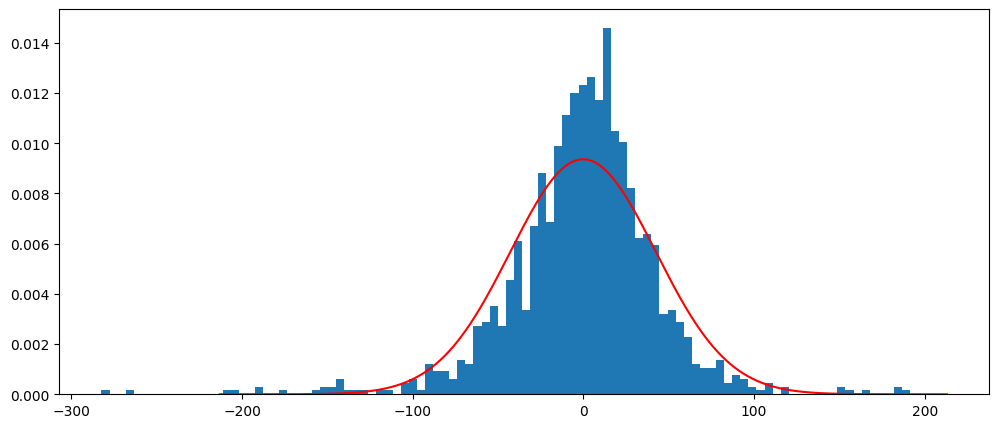

In [ ]:
mu = combined['Log Return'].mean()
s_dev = combined['Log Return'].std()
x_ax = np.linspace(-5*s_dev, 5*s_dev, 1000)


plt.figure(figsize=(12, 5))
plt.hist(combined['Log Return'], bins = 100, density = True)
plt.plot(x_ax, stats.norm.pdf(x_ax, mu, s_dev), color='r')
plt.show()

In [ ]:
combined

,Log Return,VSTOXX,VIX
Date,,,
1999-01-08,76.149611,27.76232,24.3240
1999-01-15,-98.867949,38.39124,29.1780
1999-01-22,1.609874,37.94906,30.1775
1999-01-29,17.389101,40.39532,28.8900
1999-02-05,-9.112456,38.44296,28.5720
...,...,...,...
2025-07-04,-2.832370,17.87280,16.8120
2025-07-11,15.798117,17.11912,16.5440
2025-07-18,1.028076,17.92778,16.9340


In [ ]:
combined.to_csv('combined.csv')

#**R Log-garch-x pack**

In [ ]:
install.packages("lgarch")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’




In [ ]:
library(lgarch)
library(zoo)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [ ]:
df

,Date,Close,VSTOXX,VIX,EURCHF,EURGBP,EURUSD,EURJPY,iBoxx,Euribor6m,FSI
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2000-01-07,-29.02419914,31.08464,25.0160,3.48605931,6.5500674,21.5146567,49.759626,-1.858260737,3.54480,0.42460
2,2000-01-14,-10.83741738,27.49348,21.6840,2.91644897,-12.0145618,-16.0677504,-11.509316,-3.092089252,3.53880,0.33480
3,2000-01-21,-31.96212896,27.57092,21.4475,-2.17101472,-14.6106495,-3.5618916,-13.628671,-1.095735760,3.52920,0.18550
4,2000-01-28,-25.02079876,29.04040,23.9600,-0.55902359,-15.1592951,-34.6913885,-13.145550,-1.133075606,3.58720,0.06120
5,2000-02-04,-1.30543837,29.82912,23.0140,-2.11469167,24.4374604,8.1758248,9.162992,5.692623785,3.68980,0.06480
6,2000-02-11,11.92585339,29.46712,22.8860,-1.18369014,3.5581471,3.9616081,19.103766,-2.657466651,3.69340,0.00560
7,2000-02-18,20.04304241,32.13940,23.9960,-0.68593524,-5.9914356,-0.2027781,18.196595,1.513103132,3.70580,-0.01520
8,2000-02-25,13.68978459,29.58830,24.8325,3.05191604,-8.8091924,-12.2425524,-16.520149,6.811910774,3.80620,0.06850
9,2000-03-03,14.47646813,27.55946,21.9920,-0.99552024,-3.1180792,-14.9958857,-38.513723,0.003062595,3.82520,0.08240


In [ ]:
df <- read.csv("combined.csv")
df <- df[order(df$Date), ]
Y  <- zoo(df$Log.Return,  order.by = df$Date)
X_orig = list()
X = list()

exog <- df[, c("Date",	"VSTOXX",	"VIX",	"EURCHF",	"EURGBP",	"EURUSD",	"EURJPY",	"iBoxx",	"Euribor6m",	"FSI")]

for (i in 2:ncol(exog)) {
  value <- zoo(exog[, i], order.by = exog$Date)
  X_orig[[i-1]] <- value
  X[[i-1]] <- glag(value, 1)
}
X <- do.call(cbind, X)


Rolling window

In [ ]:
length(y)

[1] 0

In [ ]:
###############################################
###############################################

df <- read.csv("combined.csv")

df <- df[order(df$Date), ]   # makes sure ascending (oldest to newest)

y  <- zoo(df$Log.Return,  order.by = df$Date)
# x1 <- zoo(df$VSTOXX, order.by = df$Date)
# x2 <- zoo(df$VIX, order.by = df$Date)

# X <- cbind(x1_1 = glag(x1, 1),
#           x2_1 = glag(x2, 1))
X_orig = list()
X = list()

exog <- df[, c("Date",	"VSTOXX", "FSI")]

for (i in 2:ncol(exog)) {
  value <- zoo(exog[, i], order.by = exog$Date)
  X_orig[[i-1]] <- value
  X[[i-1]] <- glag(value, 1)
}
X <- do.call(cbind, X)

nvar = ncol(exog)-1


H <- length(y)
S <- round(H/1.7)

vol_Log_GARCHX <- numeric(H)

keep <- complete.cases(y, X)
mu_hat <- mean(as.numeric(y[keep]))
y_c <- y - mu_hat
y_train <- y_c[keep][1:S]
X_train <- X[keep, ][1:S]

fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train),
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

vol_Log_GARCHX[1:S] <- fitted(fit)
yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][1:S], 1)))

h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) #### comment last term as well to switch off X
vol_Log_GARCHX[S+1] <- exp(0.5 * h_T1)

for (t in (S+1):(H-1)) {
y_train <- y_c[keep][(t - S + 1):t]
X_train <- X[keep, ][(t - S + 1):t]

fit <- lgarch(as.numeric(y_train),
              arch = 1, garch = 1,
              xreg = as.matrix(X_train),
              method = "ml")
cf   <- coef(fit)                 # parameter vector
w    <- cf[1]                     # intercept
a1   <- cf[2]                     # alpha_1
b1   <- cf[3]                     # beta_1
lam  <- cf[-(1:3)]                # lambda's for x_{t-1}; should match colnames(X)

yT   <- as.numeric(tail(y_train, 1))
hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))
xT_vec <- sapply(X_orig, function(x) as.numeric(tail(x[keep][(t - S + 1):t], 1)))
  # c(as.numeric(tail(x1[keep][(t - S + 1):t], 1)),
  # as.numeric(tail(x2[keep][(t - S + 1):t], 1)))
h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:nvar] * xT_vec) #### comment last term as well to switch off X
vol_Log_GARCHX[t+1] <- exp(0.5 * h_T1)
}
# yT   <- as.numeric(tail(y[keep], 1))
# hT   <- 2 * log(as.numeric(tail(fitted(fit), 1)))

# xT_vec <- c(
#   as.numeric(tail(x1[keep], 1)),  # x1_T
#   as.numeric(tail(x2[keep], 1))   # x2_T
# )

# h_T1  <- w + a1 * log(yT^2) + b1 * hT + sum(lam[1:2] * xT_vec)
# sigma_T1 <- exp(0.5 * h_T1)







# V  <- vcov(fit)                 # variance–covariance matrix
# se <- sqrt(diag(V))             # standard errors
# z  <- cf / se                   # z/t statistics (QML)
# p  <- 2 * pnorm(-abs(z))

# coef_table <- data.frame(
#   term      = names(cf),
#   estimate  = cf,
#   std.error = se,
#   z.value   = z,
#   p.value   = p,
#   row.names = NULL
# )
# print(coef_table, digits = 4)


In [ ]:
sig_zoo <- zoo(vol_Log_GARCHX, order.by = index(y)[keep])
out <- data.frame(
  Date       = as.Date(index(sig_zoo)),
  sigma_hat  = as.numeric(sig_zoo)
)

write.csv(out, "vol_Log_GARCHX_FSI_VSTOXX.csv", row.names = FALSE)

In [ ]:
vol_Log_GARCHX

[1]  36.53417  35.37055  37.23988  41.26472  32.83392  33.41336  35.11713
   [8]  34.49914  35.00511  33.13230  33.07218  31.71698  32.32743  39.34509
  [15]  28.67285  31.05023  33.30104  36.35323  35.60941  26.42705  25.56041
  [22]  27.55910  26.29307  17.70070  21.01090  21.81114  24.43596  21.23612
  [29]  20.52836  16.17412  16.80921  19.09769  19.32943  18.35351  17.55311
  [36]  19.09916  21.40575  22.68395  22.99722  19.64768  24.93485  29.06854
  [43]  24.08802  27.41175  30.11712  25.55308  31.36800  30.49492  31.53933
  [50]  32.35575  29.47186  31.89181  32.90942  34.64314  29.68262  28.23125
  [57]  26.60200  22.53399  22.40107  25.97490  24.93530  25.89152  33.77451
  [64]  38.42379  46.15868  41.06401  45.26226  35.78716  36.30858  34.14671
  [71]  37.46623  33.55895  34.51041  33.44209  31.60466  31.56992  25.91237
  [78]  21.70926  24.97484  26.75613  27.90536  27.53559  28.69427  29.97509
  [85]  23.88567  27.35811  28.41959  33.89203  45.14603  70.20143  73.14660
  [92]  59.46985  63.60456  67.08776  70.80455  65.62072  68.76895  75.07378
  [99]  67.41748  61.89938  62.67728  63.18586  60.72143  55.51301  52.54665
 [106]  50.62548  47.21643  48.02158  31.53616  36.70623  34.67474  37.16991
 [113]  42.35735  42.86865  40.65640  38.86173  36.35218  32.55832  28.14076
 [120]  30.58471  31.07081  30.39331  30.39404  30.65963  31.23369  26.78389
 [127]  29.39374  31.89258  31.50816  30.39041  29.85590  33.96595  41.47247
 [134]  53.85939  48.31492  58.70350  51.20051  55.68525  54.81579  63.68231
 [141]  65.02326  75.85279  79.78862  92.38674 100.00081 110.56751 104.58579
 [148]  93.40712  61.13394  62.86913  65.76366  62.17712  63.58853  61.52213
 [155]  61.09596  62.62364  66.04743  39.10653  41.14173  44.67313  43.86516
 [162]  47.61513  52.07322  35.64377  38.84190  41.85913  51.36836  61.08284
 [169]  63.48095  66.15116  60.01220  57.91948  46.13947  43.34203  35.86962
 [176]  34.93252  35.20939  37.92603  37.69008  36.82933  39.37722  40.70411
 [183]  37.25026  38.45194  38.13118  32.43065  36.18926  35.75506  37.60268
 [190]  35.68476  35.95722  36.70646  32.82924  32.70824  36.66298  37.99969
 [197]  34.78597  34.79329  35.42217  37.96491  37.22205  32.02446  34.56783
 [204]  35.91694  35.52816  30.37656  27.88662  20.43809  22.43027  19.00320
 [211]  21.04356  20.81501  22.43571  17.42353  16.38084  17.35917  17.24014
 [218]  18.64932  22.75428  24.26530  14.58697  17.28097  19.60889  20.89844
 [225]  21.27545  24.08892  26.74598  28.93645  26.81374  24.37087  26.31616
 [232]  25.25406  24.16805  22.87322  22.56742  21.77469  22.10089  23.48646
 [239]  24.53561  25.41733  25.68634  25.82822  28.87640  31.24563  25.31146
 [246]  26.18922  25.41007  25.84766  25.89782  24.67173  22.85700  22.96601
 [253]  24.25787  22.55349  17.88430  16.39652  14.86983  13.17544  12.97633
 [260]  13.92294  13.28756  16.01753  15.69019  14.77129  14.07582  15.37003
 [267]  17.15557  16.30789  15.17990  15.88877  16.26429  17.02123  17.31886
 [274]  14.29815  15.78031  17.36126  18.21316  20.04106  21.65906  19.77103
 [281]  20.81851  19.49619  20.41628  20.44781  20.60958  20.93468  22.21044
 [288]  20.64329  21.90255  22.40528  19.24368  18.57656  18.78267  17.86912
 [295]  19.89667  20.40282  22.36742  21.02239  20.58362  23.50167  23.27907
 [302]  20.44346  23.18771  19.64873  23.73316  25.96143  23.93885  23.16010
 [309]  22.06752  21.07049  19.57935  20.82725  18.04463  18.62964  17.48673
 [316]  19.29965  22.35669  21.38137  22.78880  23.67554  25.38986  26.83364
 [323]  25.48732  24.58209  21.44513  20.24043  17.59382  19.27779  19.79095
 [330]  17.65423  17.08588  17.85432  20.60144  18.15992  19.22933  24.07540
 [337]  25.01566  27.76476  27.85506  25.45807  29.06399  27.47486  29.48893
 [344]  26.78314  25.73986  27.52962  17.55087  18.13861  20.02777  20.90636
 [351]  18.75952  19.82998  21.61410  22.88244  22.43877  18.98758  17.75385
 [358]  18.16093  16.30459  15.62262  16.37718  18.12333  19.96013  19.37746

**End of R**

#**Python Log-garch-X**

In [ ]:
combined['Log Return'].mean()

np.float64(0.18493897218171884)

In [ ]:
eps = 1e-5 # to avoid numerical issues lates, a few rows of all sample 13 out of >3000 for daily data and 2 value out of >800 for weekly
combined.loc[abs(combined['Log Return']) < eps, 'Log Return'] = 1e-2

In [ ]:
combined.loc[abs(combined['Log Return']) < 1e-1, 'Log Return']

,Log Return
Date,
2000-04-28,-3.191472e-02
2007-08-31,4.632740e-02
2014-11-14,-7.393442e-02
2019-10-25,8.659740e-14
2024-01-26,8.406540e-02


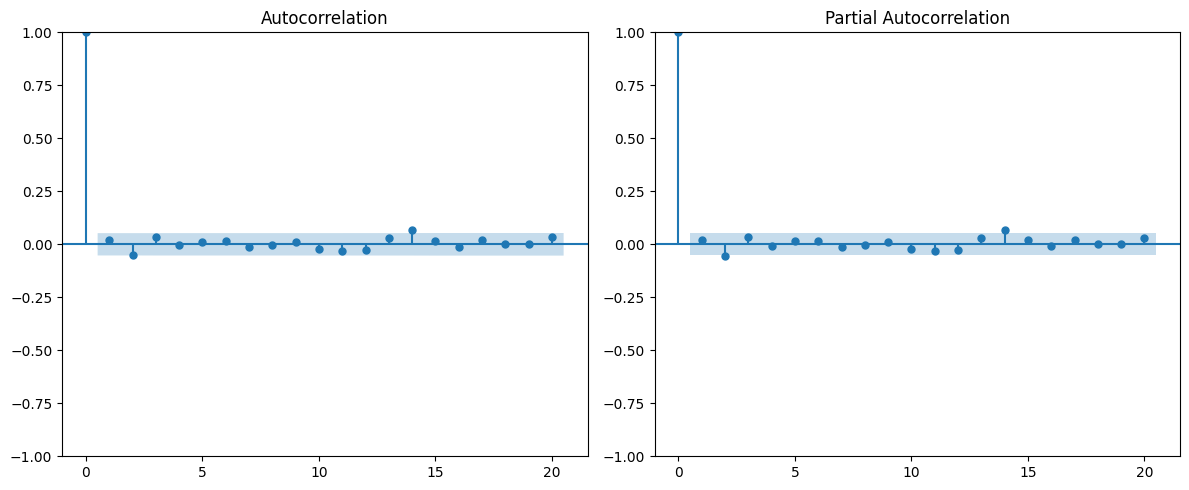

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(combined['Log Return'], lags=20, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(combined['Log Return'], lags=20, ax=plt.gca(), method="ywm")  # PACF plot (Yule-Walker method)

plt.tight_layout()
plt.show()


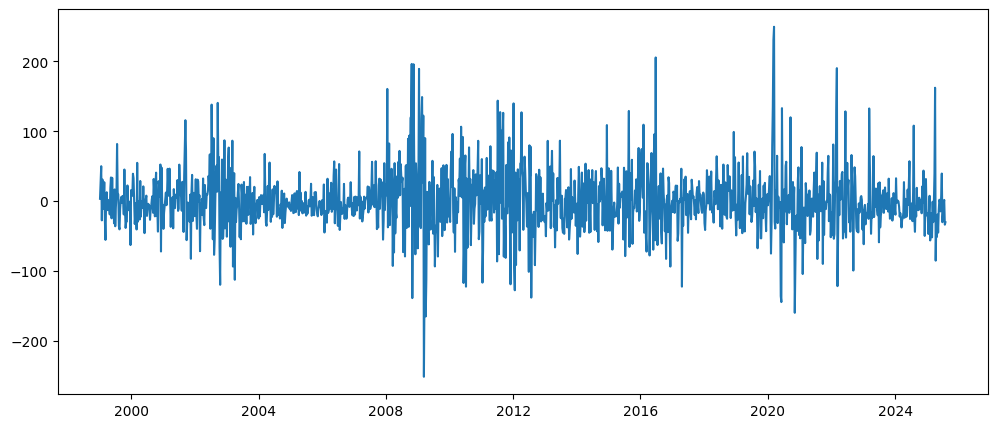

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(combined.index, combined['Log Return'])
plt.show()


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning as SMValueWarning

warnings.filterwarnings("ignore", category=SMValueWarning)
# (optional: only suppress that exact message)
# warnings.filterwarnings("ignore", message=r"No frequency information was provided, so inferred frequency .* will be used", category=SMValueWarning)
warnings.filterwarnings("ignore")


In [ ]:
def scale(x):
  return x - np.mean(x)

lsdf = pd.DataFrame()
y = np.log(scale(combined['Log Return'])**2)
X_lagged = combined[['VSTOXX']].shift(1).dropna() # so far better off with only VSTOXX
for a in range(400, 500):
  mod = sm.tsa.SARIMAX(y[a+1:], order=(1,0,1), trend='c',
                      enforce_stationarity=False, exog=X_lagged[a:], enforce_invertibility=False)
  res = mod.fit(disp=False)
  lsdf = pd.concat([res.params[['ar.L1', 'ma.L1']].to_frame().T, lsdf])



In [ ]:
lsdf1 = lsdf.copy()

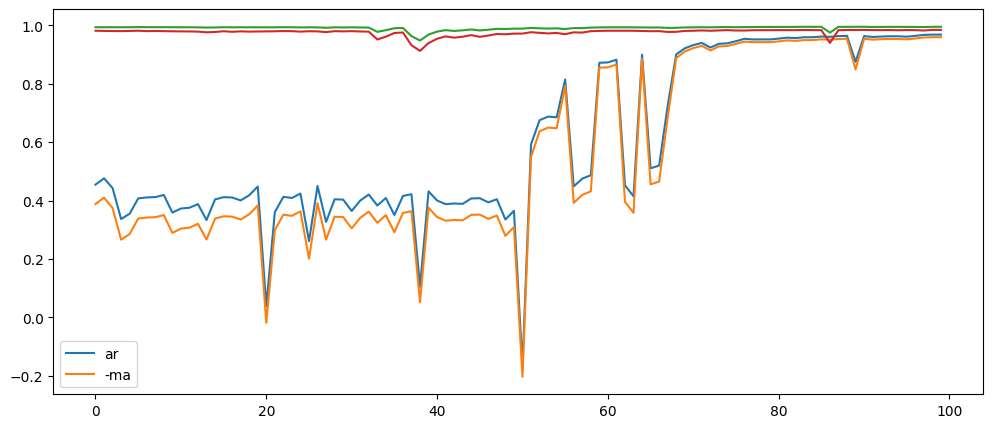

In [ ]:
lsdf.reset_index(drop=True, inplace=True)
plt.figure(figsize=(12, 5))
plt.plot(lsdf.index, lsdf['ar.L1'])
plt.plot(lsdf.index, -lsdf['ma.L1'])
plt.plot(lsdf1.index, lsdf1['ar.L1'])
plt.plot(lsdf1.index, -lsdf1['ma.L1'])

plt.legend(['ar', '-ma'])
plt.show()

In [ ]:
lsdf

,alpha,beta
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN


In [ ]:
y

,Log Return
Date,
1999-01-08,2.387698
1999-01-15,6.494776
1999-01-22,7.821000
1999-01-29,6.629715
1999-02-05,6.857951
...,...
2025-07-04,5.542766
2025-07-11,2.696800
2025-07-18,1.026825


In [ ]:
y = np.log(combined['Log Return']**2)

mod = sm.tsa.SARIMAX(y[1:], order=(1,0,1), trend='c',
                     enforce_stationarity=False, exog=X_lagged, enforce_invertibility=False)
res = mod.fit(disp=False)
print(res.summary())

# Eq. (9): smearing estimator of E[ln eta^2]
u = res.resid
Eln_eta2 = -np.log(np.mean(np.exp(u)))

# Conditional mean of ln eps^2_t (ARMA fitted values)
ln_eps2_hat = res.fittedvalues          # = ω* + φ y_{t-1} + θ u_{t-1}

# Conditional log-variance and (optionally) σ_t
logsig2_hat = ln_eps2_hat - Eln_eta2    # eq. just after (9)
sigma_hat = np.sqrt(np.exp(logsig2_hat))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                 1386
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3129.561
Date:                Fri, 03 Oct 2025   AIC                           6269.122
Time:                        17:09:09   BIC                           6295.285
Sample:                    01-15-1999   HQIC                          6278.908
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0194      0.013      1.478      0.139      -0.006       0.045
VSTOXX         0.0718      0.008      9.111      0.000       0.056       0.087
ar.L1          0.9954      0.003    322.631      0.0

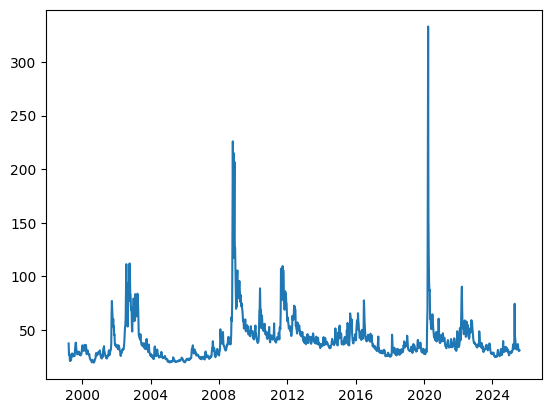

In [ ]:
plt.plot(combined[10:].index, sigma_hat[9:])

In [ ]:
ln_E_sq = np.log(combined['Log Return'] ** 2)


In [ ]:
ln_E_sq = ln_E_sq.to_frame()
ln_E_sq[ln_E_sq['Log Return'] == np.min(ln_E_sq['Log Return'])]

,Log Return
Date,
2019-10-25,-9.21034


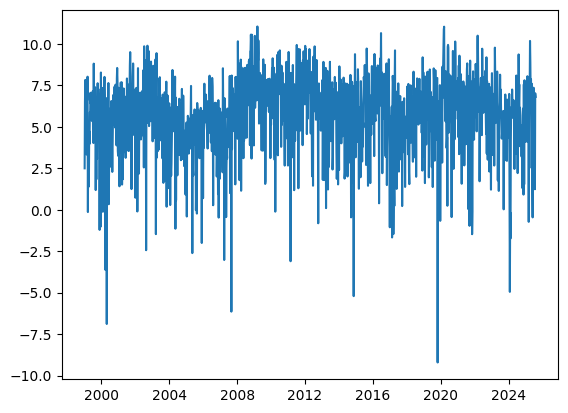

In [ ]:
plt.plot(ln_E_sq)

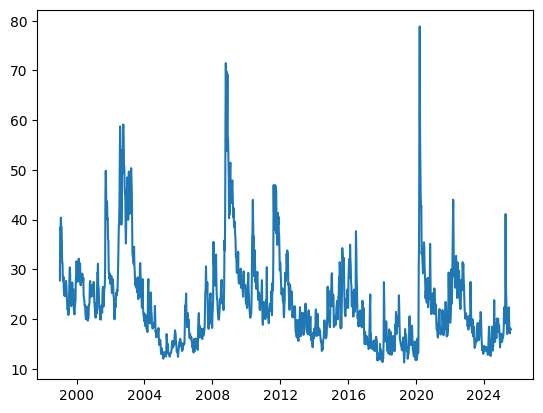

In [ ]:
plt.plot(combined.index, combined['VSTOXX'])

In [ ]:
len(combined[['VSTOXX']])

1387

In [ ]:
H = int(round(len(combined),0))# len(combined)
T = int(round(H/1.7,0))


In [ ]:
ln_E_sq[:10]

,Log Return
Date,
1999-01-08,2.496761
1999-01-15,6.509103
1999-01-22,7.828395
1999-01-29,6.616228
1999-02-05,6.869907
1999-02-12,4.818365
1999-02-19,3.331146
1999-02-26,6.606107
1999-03-05,6.608896


In [ ]:
def scale(x):
    return (x - np.mean(x))# /np.std(x)
a = 0

X_lagged = combined[['VSTOXX']][a:H].shift(1).dropna() # so far better off with only VSTOXX
model = sm.tsa.SARIMAX(trend='c', endog=ln_E_sq[a+1:H], exog=X_lagged, order=(1,0,1), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

print(res.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                 1386
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3129.561
Date:                Fri, 03 Oct 2025   AIC                           6269.122
Time:                        17:08:31   BIC                           6295.285
Sample:                    01-15-1999   HQIC                          6278.908
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0194      0.013      1.478      0.139      -0.006       0.045
VSTOXX         0.0718      0.008      9.111      0.000       0.056       0.087
ar.L1          0.9954      0.003    322.631      0.0

In [ ]:

residuals = res.resid
esimate_E_nu_sq = - np.log(np.mean(np.exp(residuals)))
parameters = pd.Series(res.params, index=res.param_names)
beta = - parameters['ma.L1']
alpha = parameters['ar.L1'] - beta
omega = parameters['intercept'] - (1 - beta) * esimate_E_nu_sq
[omega,alpha,beta]

[np.float64(0.26390049180912595),
 np.float64(0.05920630510213454),
 np.float64(0.9178164584037987)]

In [ ]:

LR_log_var = (omega + alpha*esimate_E_nu_sq + parameters['VSTOXX'] * np.mean(X_lagged))/(1- (alpha + beta))
cond_log_var_full_s = np.zeros(H)
cond_log_var_full_s[0] = LR_log_var
for i in range(H-1):
    cond_log_var_full_s[i+1] = omega + alpha * np.log(combined['Log Return'][i] ** 2) + beta * cond_log_var_full_s[i] + parameters['VSTOXX'] * combined['VSTOXX'][i]

/tmp/ipython-input-541344466.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond_log_var_full_s[i+1] = omega + alpha * np.log(combined['Log Return'][i] ** 2) + beta * cond_log_var_full_s[i]


In [ ]:
H

433

In [ ]:
temp = cond_log_var_full_s.copy()

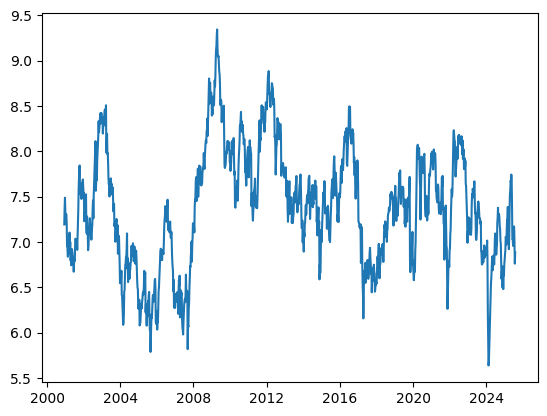

In [ ]:
plt.plot(combined[100:H].index,cond_log_var_full_s[100:H])

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning as SMValueWarning

warnings.filterwarnings("ignore", category=SMValueWarning)
# (optional: only suppress that exact message)
# warnings.filterwarnings("ignore", message=r"No frequency information was provided, so inferred frequency .* will be used", category=SMValueWarning)
warnings.filterwarnings("ignore")


# rolling window estimation:
cond_log_var = np.zeros(len(combined))
# LR_log_var = (omega + alpha*esimate_E_nu_sq + parameters['VSTOXX'] * np.mean(X_lagged))/(1- (alpha + beta))
# cond_log_var[0] = LR_log_var
X_lagged = combined[['VSTOXX']].shift(1).dropna()

for t in range(T,H):
  model = sm.tsa.SARIMAX(trend='c', endog=ln_E_sq[t+1-T:t], order=(1,0,1), exog=X_lagged[t-T:t-1], enforce_stationarity=False, enforce_invertibility=False)
  res = model.fit(disp=False)
  residuals = res.resid
  esimate_E_nu_sq = - np.log(np.mean(np.exp(residuals)))
  parameters = pd.Series(res.params, index=res.param_names)
  beta = - parameters['ma.L1']
  alpha = parameters['ar.L1'] - beta
  omega = parameters['intercept'] - (1 - beta) * esimate_E_nu_sq
  if t == T:
    print(f'beta {beta}, alpha {alpha}, Enusq {esimate_E_nu_sq}, omega {omega}')
    LR_log_var = (omega + alpha*esimate_E_nu_sq + parameters['VSTOXX'] * np.mean(X_lagged[t-T:t-1]))/(1- (alpha + beta))
    cond_log_var[0] = LR_log_var
    for i in range(1, t+1):
      cond_log_var[i] = omega + alpha * np.log(combined['Log Return'][i-1] ** 2) + beta * cond_log_var[i-1] + parameters['VSTOXX'] * combined['VSTOXX'][i-1]
  else:
    cond_log_var[t] = omega + alpha * np.log(combined['Log Return'][t-1] ** 2) + beta * cond_log_var[t-1] + parameters['VSTOXX'] * combined['VSTOXX'][t-1]
# for t in range(int(H-T)):
#   model = sm.tsa.SARIMAX(trend='c', endog=ln_E_sq[t+1:int(T+t)], order=(1,0,1), exog=X_lagged[t:int(T+t-1)], enforce_stationarity=False, enforce_invertibility=False)
#   res = model.fit(disp=False)
#   residuals = res.resid
#   esimate_E_nu_sq = - np.log((1 / len(residuals)) * np.sum(np.exp(residuals)))
#   parameters = pd.Series(res.params, index=res.param_names)
#   beta = - parameters['ma.L1']
#   alpha = parameters['ar.L1'] - beta
#   omega = parameters['intercept'] - (1 - beta) * esimate_E_nu_sq
#   for i in range(t, T + t):
#     cond_log_var[i+1] = omega + alpha * np.log(combined['Log Return'][i] ** 2) + beta * cond_log_var[i] + parameters['VSTOXX'] * combined['VSTOXX'][i]





beta 1.0000734592284353, alpha 0.0018262019648220829, Enusq -1.3699970436584528, omega -0.004065776487549749


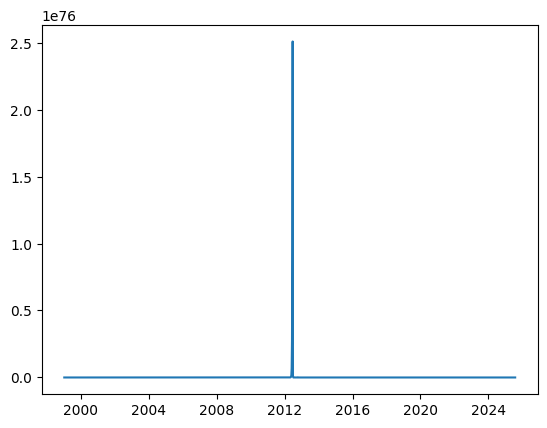

In [ ]:
vol_Log_GARCHX = np.sqrt(np.exp(cond_log_var))
plt.plot(combined.index,vol_Log_GARCHX)
plt.show()

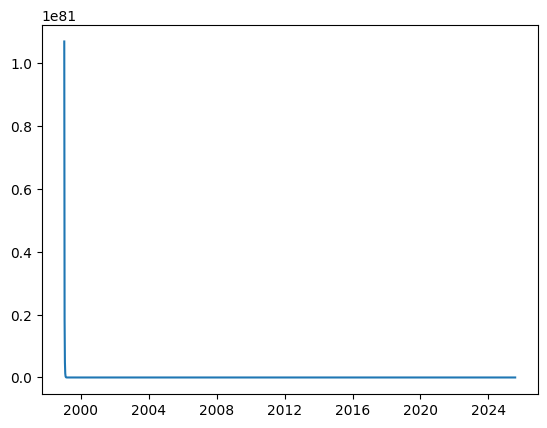

In [ ]:
vol_Log_GARCHX_full_s = np.sqrt(np.exp(cond_log_var_full_s))
plt.plot(combined[:H].index,vol_Log_GARCHX_full_s)
plt.show()

In [ ]:
vol_Log_GARCHX = pd.read_csv('vol_Log_GARCHX.csv')
vol_Log_GARCHX['Date'] = pd.to_datetime(vol_Log_GARCHX['Date'])
vol_Log_GARCHX.set_index('Date', inplace=True)
vol_Log_GARCHX.at['1999-01-08', 'sigma_hat'] = np.mean(vol_Log_GARCHX)

In [ ]:
H = len(combined)
T = int(round(H/1.7,0))

#**Other models**

In [ ]:
H=len(combined)
T=int(round(H*0.6,0))

In [ ]:
!pip install arch
from arch.univariate import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.2 MB/s eta 0:00:00


In [ ]:
# GARCH(1,1)
vol_GARCH = np.zeros(len(combined))
# model = arch_model(combined['Log Return'][:H], mean='Constant',
#                 vol='GARCH', p=1, q=1, dist='StudentsT')
# res_garch = model.fit(disp=False)
# vol_GARCH[:H] = res_garch.conditional_volatility
# print(res_garch.summary())


for t in range(T,H):#H-T
  model = arch_model(combined['Log Return'][t-T:t], mean='Constant',
                  vol='GARCH', p=1, q=1, dist='StudentsT')
  res_garch = model.fit(disp=False)
  if t == T:
    vol_GARCH[t-T:T] = res_garch.conditional_volatility
    vol_GARCH[t] = np.sqrt(res_garch.forecast(horizon=1).variance.values[-1, 0])
  else:
    vol_GARCH[t] = np.sqrt(res_garch.forecast(horizon=1).variance.values[-1, 0])


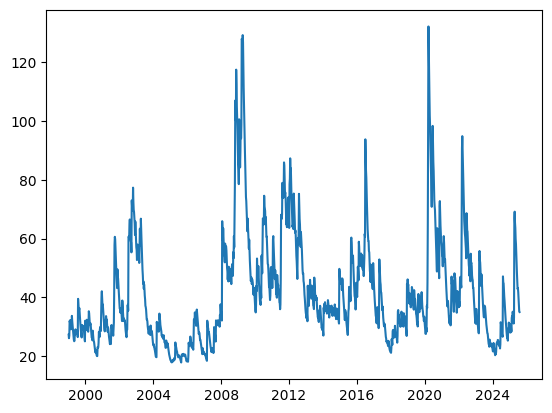

In [ ]:
plt.plot(combined.index[:H], vol_GARCH[:H])

In [ ]:
# TGARCH(1,1)
vol_TGARCH = np.zeros(len(combined))
# model = arch_model(combined['Log Return'][:H], mean='Constant',
#                 vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
# res_tgarch = model.fit(disp=False)
# vol_TGARCH[:H] = res_tgarch.conditional_volatility
# print(res_tgarch.summary())

for t in range(T,H):
  model = arch_model(combined['Log Return'][t-T:t], mean='Constant',
                  vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
  res_tgarch = model.fit(disp=False)
  if t == T:
    vol_TGARCH[t-T:t] = res_tgarch.conditional_volatility
    vol_TGARCH[t] = np.sqrt(res_tgarch.forecast(horizon=1).variance.values[-1, 0])
  else:
    vol_TGARCH[t] = np.sqrt(res_tgarch.forecast(horizon=1).variance.values[-1, 0])



In [ ]:
vol_Log_GARCHX=pd.read_csv('vol_Log_GARCHX.csv')['sigma_hat'].to_numpy()
vol_Log_GARCHX = np.concatenate(([np.mean(vol_Log_GARCHX)],vol_Log_GARCHX))

# **GARCH-X python**

In [ ]:
y = combined['Log Return'].to_numpy()
X = combined[['FSI','VSTOXX']].to_numpy()

def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu, x_t_lagged, gamma):
  omega, alpha, beta = theta
  return omega + alpha * (y_t_lagged - mu) ** 2 + beta * variance_t_lagged + x_t_lagged @ gamma

def total_neg_loglik(parameters, y, X, variance_0):
  omega, alpha, beta, d, mu = parameters[:5]
  gamma = parameters[5:]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta), mu, X[t-1], gamma)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def garch_x(y, X, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0], np.zeros(X.shape[1])))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (2.01, 200.0), (None, None)] + [(None, None)] * X.shape[1]
  lc = LinearConstraint(np.r_[0, 1, 1, 0, 0, np.zeros(X.shape[1])], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, X, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, d_hat, mu_hat, *gamma_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}, gamma={np.array(gamma_hat)}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat), mu_hat, X[t-1], gamma_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_GARCHX = np.empty(len(y))
parameters_GARCHX = np.empty((int(H-T),int(5+X.shape[1])))

vol_GARCHX[:T+1], parameters_GARCHX[0] = garch_x(y[:T],X[:T],variance_0)
for t in range(T+1,H):  #so far runs 17 mins
  vol, parameters_GARCHX[t-T] = garch_x(y[t-T:t], X[t-T:t], vol_GARCHX[t-T-1] ** 2, parameters_GARCHX[t-T-1])
  vol_GARCHX[t] = vol[-1]

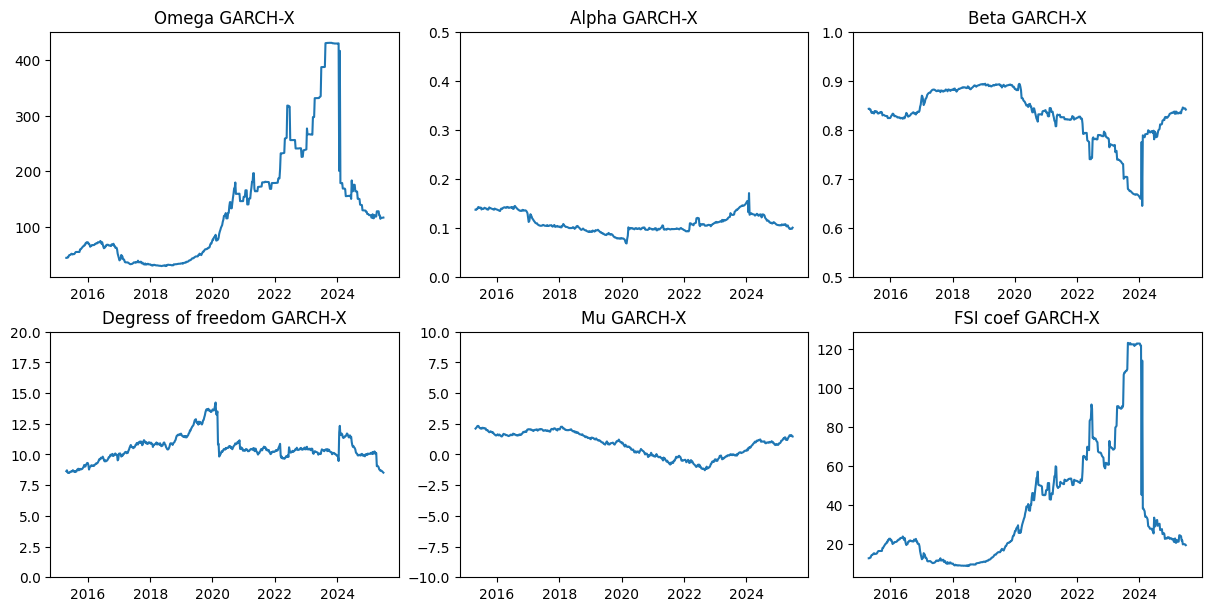

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_GARCHX[:,0]);      axs[0, 0].set_title('Omega GARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_GARCHX[:,1]);      axs[0, 1].set_title('Alpha GARCH-X'); axs[0, 1].set_ylim(0, 0.5)
axs[0,2].plot(combined[T:H].index, parameters_GARCHX[:,2]);      axs[0, 2].set_title('Beta GARCH-X'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_GARCHX[:,3]);      axs[1, 0].set_title('Degress of freedom GARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_GARCHX[:,4]);      axs[1, 1].set_title('Mu GARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_GARCHX[:,5:]);     axs[1, 2].set_title('FSI coef GARCH-X')




plt.show()

Text(0.5, 1.0, 'VSTOXX coef GARCH-X')

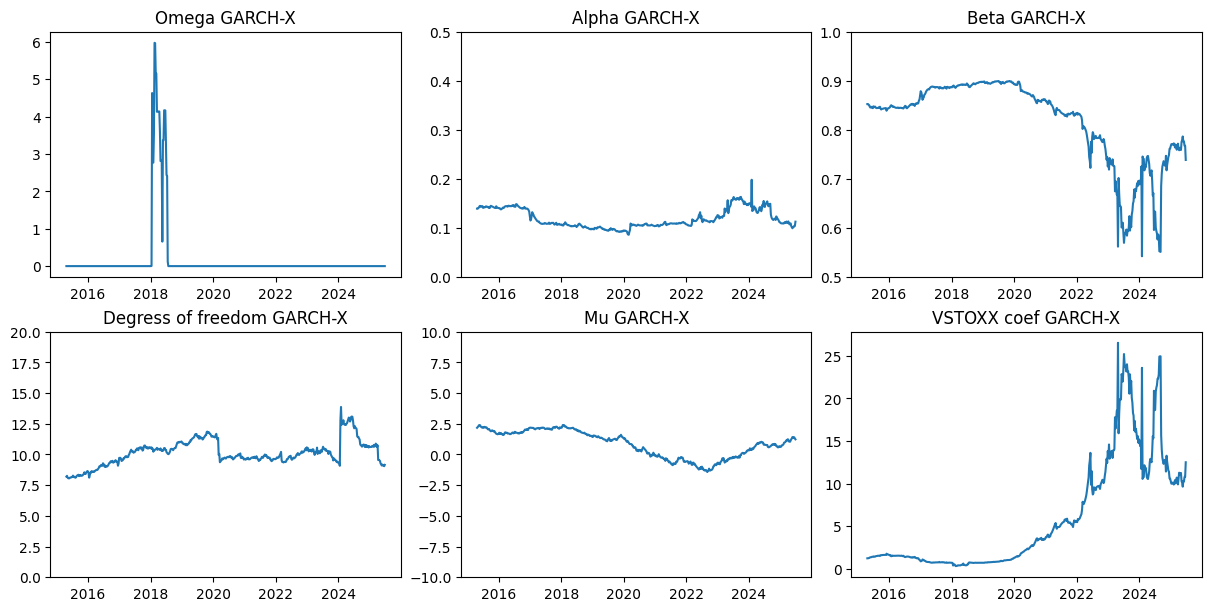

In [ ]:

fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_GARCHX[:,0]);      axs[0, 0].set_title('Omega GARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_GARCHX[:,1]);      axs[0, 1].set_title('Alpha GARCH-X'); axs[0, 1].set_ylim(0, 0.5)
axs[0,2].plot(combined[T:H].index, parameters_GARCHX[:,2]);      axs[0, 2].set_title('Beta GARCH-X'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_GARCHX[:,3]);      axs[1, 0].set_title('Degress of freedom GARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_GARCHX[:,4]);      axs[1, 1].set_title('Mu GARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_GARCHX[:,5:]);     axs[1, 2].set_title('VSTOXX coef GARCH-X')



In [ ]:
H=len(combined)
T = int(round(H*.6,0))

In [ ]:
len(vol_GARCHX)

1330

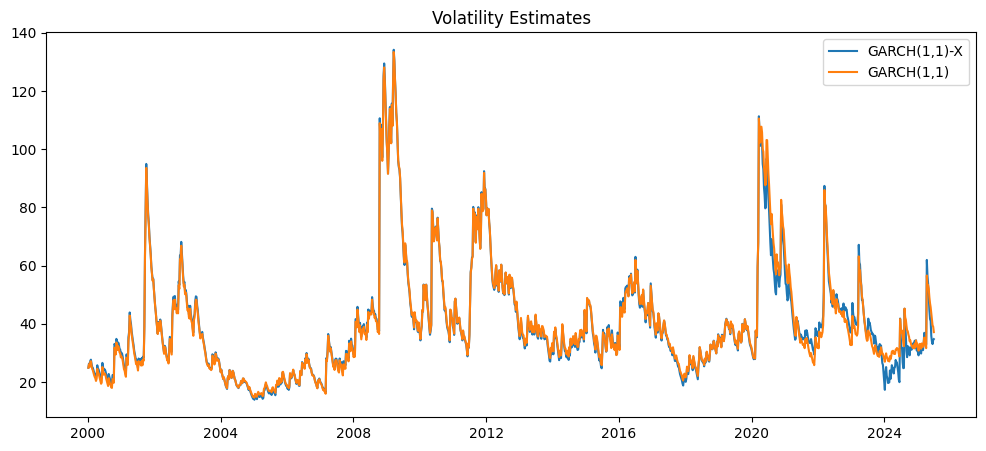

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(combined.index, vol_GARCHX, label='GARCH(1,1)-X')
plt.plot(combined.index, vol_GARCH, label='GARCH(1,1)')
plt.legend(['GARCH(1,1)-X', 'GARCH(1,1)'])
plt.title('Volatility Estimates')
plt.show()

# **GARCH**

In [ ]:
y = combined['Log Return'].to_numpy()


def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu):
  omega, alpha, beta = theta
  return omega + alpha * (y_t_lagged - mu) ** 2 + beta * variance_t_lagged

def total_neg_loglik(parameters, y, variance_0):
  omega, alpha, beta, d, mu = parameters
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln computation takes to much time inside the loop

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta), mu)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll


def garch(y, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0]))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (2.01, 200.0), (None, None)]
  lc = LinearConstraint(np.r_[0, 1, 1, 0, 0], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, d_hat, mu_hat = res.x

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat), mu_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_GARCH = np.empty(len(y))
parameters_GARCH = np.empty((int(H-T),int(5)))

vol_GARCH[:T+1], parameters_GARCH[0] = garch(y[:T],variance_0)
for t in range(T+1,H):
  vol, parameters_GARCH[t-T] = garch(y[t-T:t], vol_GARCH[t-T-1] ** 2, parameters_GARCH[t-T-1])
  vol_GARCH[t] = vol[-1]

Success: True, Optimization terminated successfully
omega=16.4605, alpha=0.131359, beta=0.867641, d=8.12844, mu=2.25452
Final NLL: 3958.589010243899
Success: True, Optimization terminated successfully
omega=16.4641, alpha=0.131288, beta=0.867712, d=8.18372, mu=2.31606
Final NLL: 3959.31869086442
Success: True, Optimization terminated successfully
omega=16.6463, alpha=0.132363, beta=0.866637, d=8.06052, mu=2.36665
Final NLL: 3958.679177860396
Success: True, Optimization terminated successfully
omega=16.8802, alpha=0.132939, beta=0.866061, d=8.00284, mu=2.4567
Final NLL: 3957.9890137550597
Success: True, Optimization terminated successfully
omega=17.2502, alpha=0.135115, beta=0.863885, d=7.99166, mu=2.4822
Final NLL: 3958.339036331658
Success: True, Optimization terminated successfully
omega=17.3245, alpha=0.136092, beta=0.862908, d=7.96898, mu=2.46952
Final NLL: 3958.638962378291
Success: True, Optimization terminated successfully
omega=17.0982, alpha=0.134409, beta=0.864591, d=8.01444,

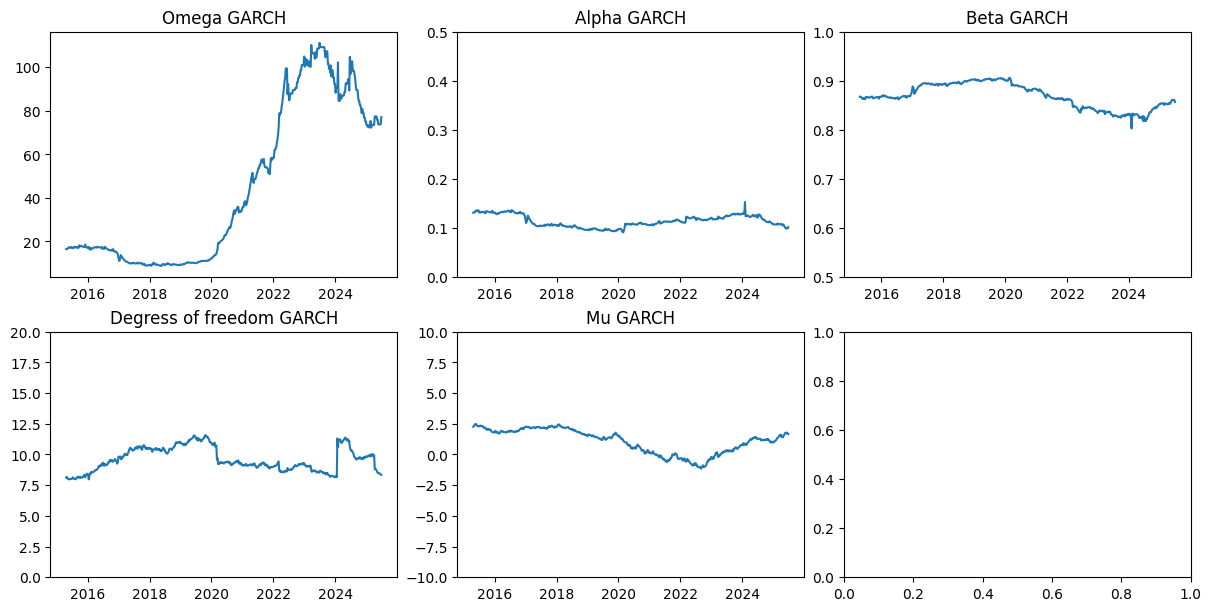

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_GARCH[:,0]);      axs[0, 0].set_title('Omega GARCH')
axs[0,1].plot(combined[T:H].index, parameters_GARCH[:,1]);      axs[0, 1].set_title('Alpha GARCH'); axs[0, 1].set_ylim(0, 0.5)
axs[0,2].plot(combined[T:H].index, parameters_GARCH[:,2]);      axs[0, 2].set_title('Beta GARCH'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_GARCH[:,3]);      axs[1, 0].set_title('Degress of freedom GARCH'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_GARCH[:,4]);      axs[1, 1].set_title('Mu GARCH'); axs[1, 1].set_ylim(-10, 10)
plt.show()


# **TGARCH-X**

In [ ]:
y = combined['Log Return'].to_numpy()
X = combined[['FSI','VSTOXX']].to_numpy()

def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu, x_t_lagged, gamma):
  omega, alpha, beta, eta = theta
  e_t_lagged = y_t_lagged - mu
  return omega + (alpha + eta * np.where(e_t_lagged < 0, 1, 0)) * (e_t_lagged) ** 2 + beta * variance_t_lagged + x_t_lagged @ gamma

def total_neg_loglik(parameters, y, X, variance_0):
  omega, alpha, beta, eta, d, mu = parameters[:6]
  gamma = parameters[6:]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0  or eta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta, eta), mu, X[t-1], gamma)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def tgarch_x(y, X, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8, 0.1]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0], np.zeros(X.shape[1])))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (0.0, 0.999) ,(2.01, 200.0), (None, None)] + [(None, None)] * X.shape[1]
  lc = LinearConstraint(np.r_[0, 1, 1, 0.5, 0, 0, np.zeros(X.shape[1])], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, X, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, eta_hat, d_hat, mu_hat, *gamma_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, eta={eta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}, gamma={np.array(gamma_hat)}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat, eta_hat), mu_hat, X[t-1], gamma_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_TGARCHX = np.empty(len(y))
parameters_TGARCHX = np.empty((int(H-T),int(6+X.shape[1])))

vol_TGARCHX[:T+1], parameters_TGARCHX[0] = tgarch_x(y[:T],X[:T],variance_0)
for t in range(T+1,H):  #so far runs 17 mins
  vol, parameters_TGARCHX[t-T] = tgarch_x(y[t-T:t], X[t-T:t], vol_TGARCHX[t-T-1] ** 2, parameters_TGARCHX[t-T-1])
  vol_TGARCHX[t] = vol[-1]

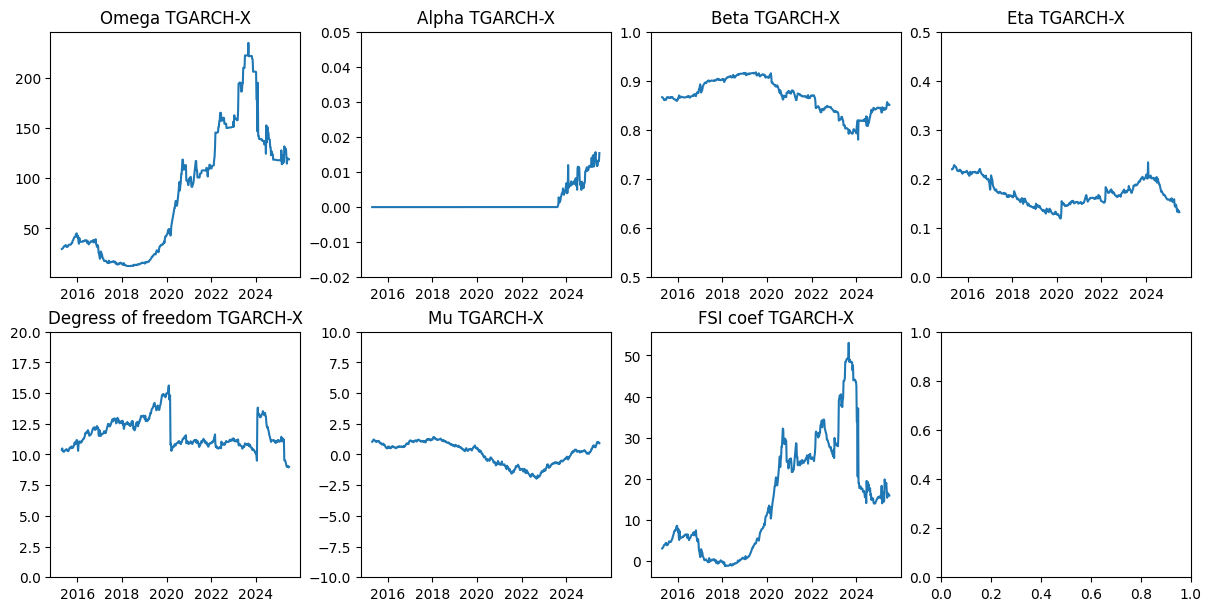

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_TGARCHX[:,0]);      axs[0, 0].set_title('Omega TGARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_TGARCHX[:,1]);      axs[0, 1].set_title('Alpha TGARCH-X'); axs[0, 1].set_ylim(-0.02, 0.05)
axs[0,2].plot(combined[T:H].index, parameters_TGARCHX[:,2]);      axs[0, 2].set_title('Beta TGARCH-X'); axs[0, 2].set_ylim(0.5, 1)
axs[0,3].plot(combined[T:H].index, parameters_TGARCHX[:,3]);      axs[0, 3].set_title('Eta TGARCH-X'); axs[0, 3].set_ylim(0, 0.5)
axs[1,0].plot(combined[T:H].index, parameters_TGARCHX[:,4]);      axs[1, 0].set_title('Degress of freedom TGARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_TGARCHX[:,5]);      axs[1, 1].set_title('Mu TGARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_TGARCHX[:,6]);      axs[1, 2].set_title('FSI coef TGARCH-X')

plt.show()

In [ ]:
parameters_TGARCHX_FSI_VSTOXX.set_index('Date', inplace=True)

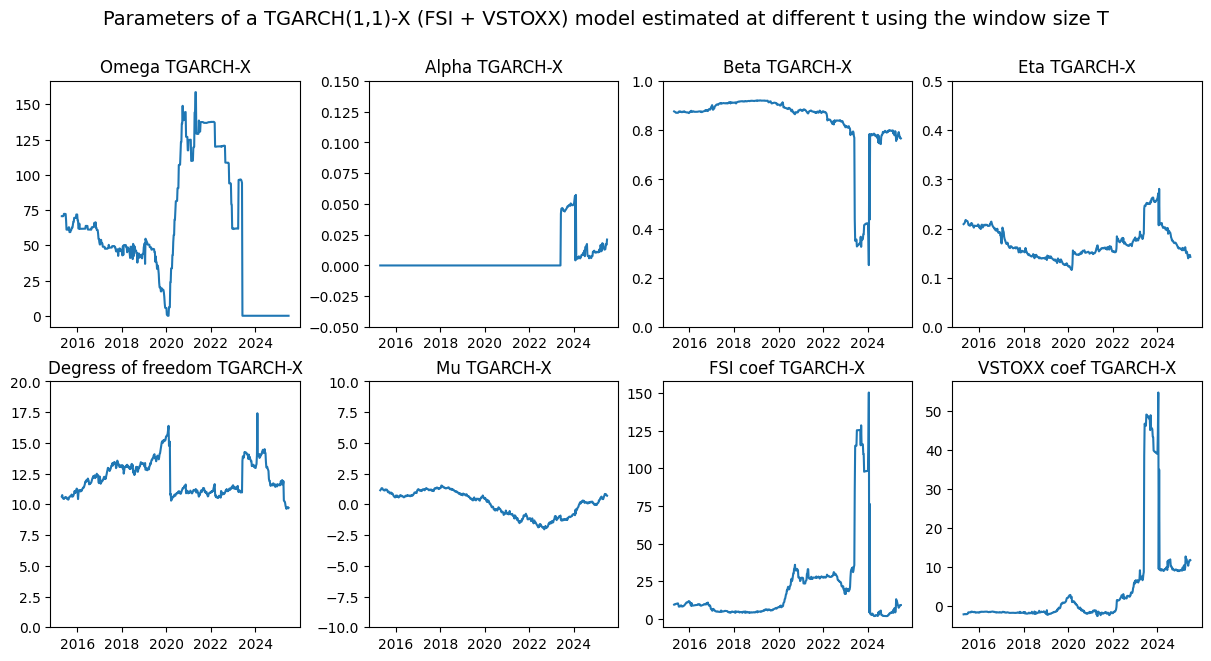

In [ ]:


fig, axs = plt.subplots(2, 4, figsize=(12, 6.5), constrained_layout=True)
fig.suptitle('Parameters of a TGARCH(1,1)-X (FSI + VSTOXX) model estimated at different t using the window size T\n', fontsize=14)
axs[0,0].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,0]);      axs[0, 0].set_title('Omega TGARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,1]);      axs[0, 1].set_title('Alpha TGARCH-X'); axs[0, 1].set_ylim(-0.05, 0.15)
axs[0,2].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,2]);      axs[0, 2].set_title('Beta TGARCH-X'); axs[0, 2].set_ylim(0.0, 1)
axs[0,3].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,3]);      axs[0, 3].set_title('Eta TGARCH-X'); axs[0, 3].set_ylim(0, 0.5)
axs[1,0].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,4]);      axs[1, 0].set_title('Degress of freedom TGARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,5]);      axs[1, 1].set_title('Mu TGARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,6]);      axs[1, 2].set_title('FSI coef TGARCH-X')
axs[1,3].plot(combined[T:H].index, parameters_TGARCHX_FSI_VSTOXX[:,7]);      axs[1, 3].set_title('VSTOXX coef TGARCH-X')


plt.show()

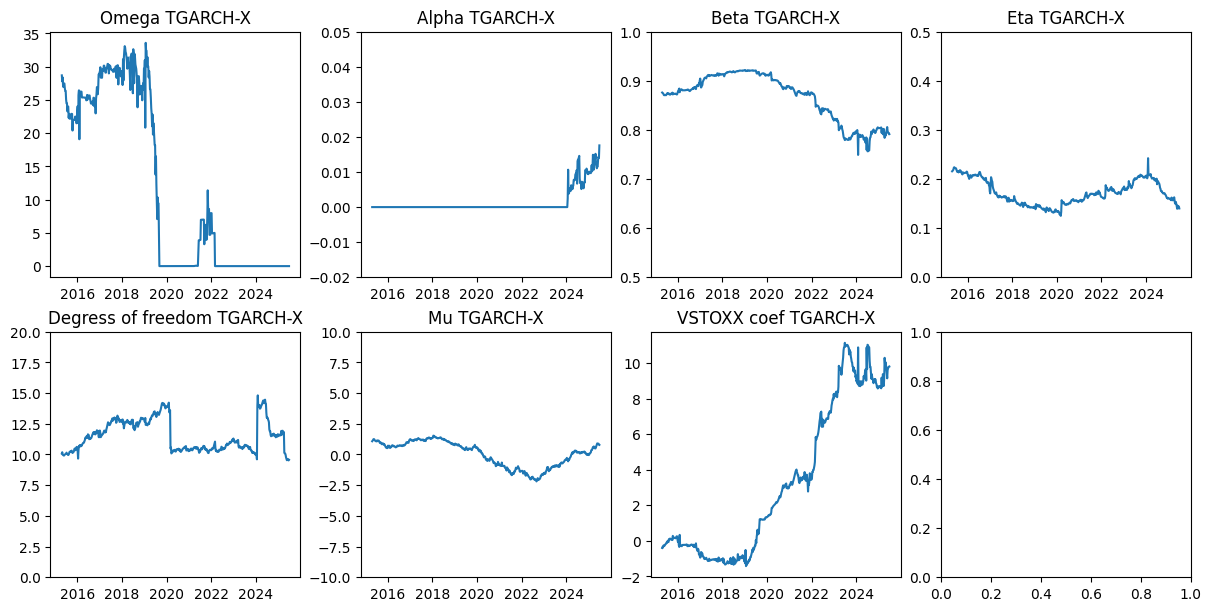

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_TGARCHX[:,0]);      axs[0, 0].set_title('Omega TGARCH-X')
axs[0,1].plot(combined[T:H].index, parameters_TGARCHX[:,1]);      axs[0, 1].set_title('Alpha TGARCH-X'); axs[0, 1].set_ylim(-0.02, 0.05)
axs[0,2].plot(combined[T:H].index, parameters_TGARCHX[:,2]);      axs[0, 2].set_title('Beta TGARCH-X'); axs[0, 2].set_ylim(0.5, 1)
axs[0,3].plot(combined[T:H].index, parameters_TGARCHX[:,3]);      axs[0, 3].set_title('Eta TGARCH-X'); axs[0, 3].set_ylim(0, 0.5)
axs[1,0].plot(combined[T:H].index, parameters_TGARCHX[:,4]);      axs[1, 0].set_title('Degress of freedom TGARCH-X'); axs[1, 0].set_ylim(0, 20)
axs[1,1].plot(combined[T:H].index, parameters_TGARCHX[:,5]);      axs[1, 1].set_title('Mu TGARCH-X'); axs[1, 1].set_ylim(-10, 10)
axs[1,2].plot(combined[T:H].index, parameters_TGARCHX[:,6]);      axs[1, 2].set_title('VSTOXX coef TGARCH-X')

plt.show()

# **TGARCH**

In [ ]:
y = combined['Log Return'].to_numpy()


def variance_t_func(y_t_lagged, variance_t_lagged, theta, mu):
  omega, alpha, beta, eta = theta
  e_t_lagged = y_t_lagged - mu
  return omega + (alpha + eta * np.where(e_t_lagged < 0, 1, 0)) * (e_t_lagged) ** 2 + beta * variance_t_lagged

def total_neg_loglik(parameters, y, variance_0):
  omega, alpha, beta, eta, d, mu = parameters[:6]
  if d <= 2 or omega <= 0 or alpha < 0 or beta < 0  or eta < 0 or (alpha + beta) >= 1:
    return 1e12 + 1e12 * (max(0, 2 - d) + max(0, (alpha + beta) - 0.999))
    # big penalty if parameters are not in the feasible region

  nll = 0.0
  variance_t_lagged = variance_0

  term1 = (gammaln((d+1) / 2) # this is a constant from t-log-likelihood function
  - gammaln(d / 2) - 0.5 * (np.log(np.pi) # it is calculated outside of loop below, because
  + np.log(d - 2)))  # gammaln takes to much time

  for t in range(1, len(y)):
    variance_t = variance_t_func(y[t-1], variance_t_lagged, (omega, alpha, beta, eta), mu)
    if variance_t <= 0 or not np.isfinite(variance_t):
      return 1e12

    temp = (y[t] - mu) ** 2 / ((d - 2) * variance_t)
    term2 = - np.log(variance_t) / 2 - ((d + 1) / 2) * np.log1p(temp)

    nll -= term1 + term2 # sum of log-likelihood functions (negative ll for minimizer)
    variance_t_lagged = variance_t
  return nll



def tgarch(y, variance_0, parameters_0=None):
  variance = np.empty(len(y)+1)
  variance[0] = variance_0

  if parameters_0 is None: # if this is not None, then we start optimizing where we finished, speeding up the computation
    theta_0 = np.array([0.1, 0.1, 0.8, 0.1]) #otherwise we initialize
    parameters_0 = np.concatenate((theta_0, [4, 0]))

  bounds = [(1e-12, None), (0.0, 0.999), (0.0, 0.999), (0.0, 0.999) ,(2.01, 200.0), (None, None)]
  lc = LinearConstraint(np.r_[0, 1, 1, 0.5, 0, 0], 0.0, 0.999) # np.r unites in 1-d np array
  res = minimize(total_neg_loglik, parameters_0,
                args = (y, variance_0), #passes the whole (y, X, variance_0) tuple as a single argument
                method = 'SLSQP', #Sequential (Least Squares) Quadratic Programming
                bounds=bounds,
                constraints=[lc],
                options={'maxiter': 300, 'ftol': 1e-6, 'disp': False}
                )
  omega_hat, alpha_hat, beta_hat, eta_hat, d_hat, mu_hat = res.x # * means rest coefs are gamma

  # print(f"Success: {res.success}, {res.message}")
  # print(f"omega={omega_hat:.6g}, alpha={alpha_hat:.6g}, beta={beta_hat:.6g}, eta={eta_hat:.6g}, d={d_hat:.6g}, mu={mu_hat:.6g}")
  # print("Final NLL:", res.fun)

  for t in range(1, len(y)+1):
      v_t = variance_t_func(y[t-1], variance[t-1], (omega_hat, alpha_hat, beta_hat, eta_hat), mu_hat)
      if v_t <= 1e-12:
        v_t = variance[t-1] # prevents the variance becoming too small or negative due to forecasting
      variance[t] = v_t
  return np.sqrt(variance), res.x



variance_0 = np.mean(y[:5] ** 2)
vol_TGARCH = np.empty(len(y))
parameters_TGARCH = np.empty((int(H-T),int(6)))

vol_TGARCH[:T+1], parameters_TGARCH[0] = tgarch(y[:T], variance_0)
for t in range(T+1,H):  #so far runs 17 mins
  vol, parameters_TGARCH[t-T] = tgarch(y[t-T:t], vol_TGARCH[t-T-1] ** 2, parameters_TGARCH[t-T-1])
  vol_TGARCH[t] = vol[-1]

Success: True, Optimization terminated successfully
omega=23.0691, alpha=0, beta=0.872203, eta=0.218277, d=10.1469, mu=1.0491
Final NLL: 3941.403905325019
Success: True, Optimization terminated successfully
omega=23.068, alpha=0, beta=0.872031, eta=0.218501, d=10.2396, mu=1.09618
Final NLL: 3942.0141568293056
Success: True, Optimization terminated successfully
omega=23.0901, alpha=8.14206e-12, beta=0.871155, eta=0.220051, d=10.0395, mu=1.14899
Final NLL: 3941.681308622449
Success: True, Optimization terminated successfully
omega=23.1823, alpha=0, beta=0.870592, eta=0.220916, d=9.98717, mu=1.22621
Final NLL: 3940.931145665155
Success: True, Optimization terminated successfully
omega=23.5649, alpha=0, beta=0.868501, eta=0.224996, d=9.96649, mu=1.23336
Final NLL: 3941.2922279013956
Success: True, Optimization terminated successfully
omega=23.732, alpha=3.69826e-13, beta=0.867766, eta=0.226099, d=9.94027, mu=1.2157
Final NLL: 3941.656463244967
Success: True, Optimization terminated success

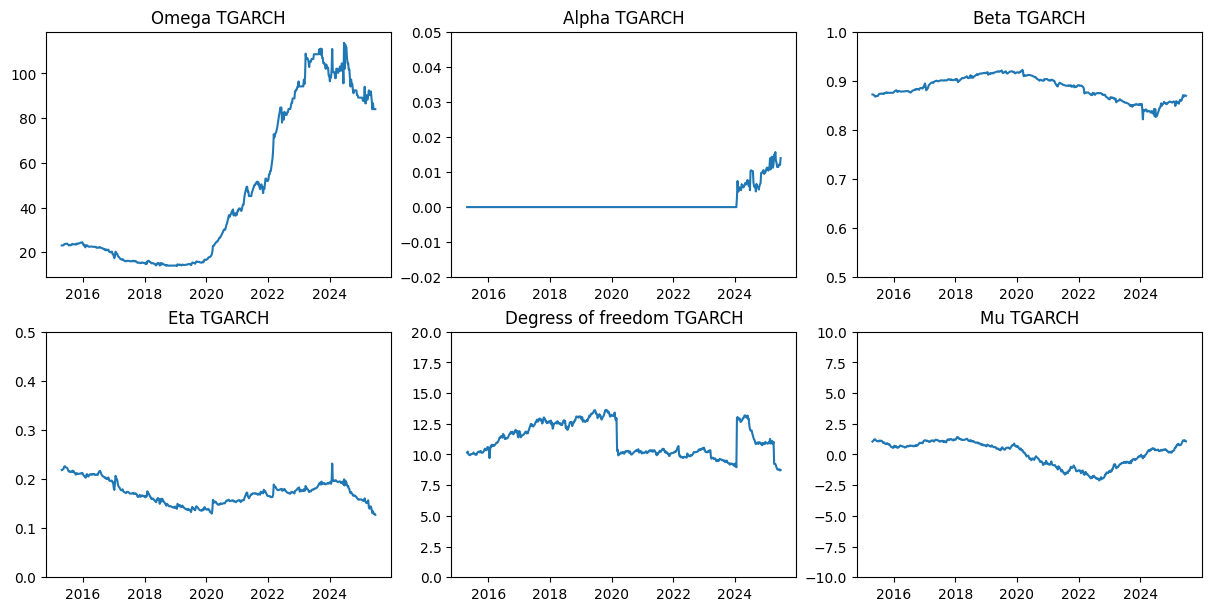

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
axs[0,0].plot(combined[T:H].index, parameters_TGARCH[:,0]);      axs[0, 0].set_title('Omega TGARCH')
axs[0,1].plot(combined[T:H].index, parameters_TGARCH[:,1]);      axs[0, 1].set_title('Alpha TGARCH'); axs[0, 1].set_ylim(-0.02, 0.05)
axs[0,2].plot(combined[T:H].index, parameters_TGARCH[:,2]);      axs[0, 2].set_title('Beta TGARCH'); axs[0, 2].set_ylim(0.5, 1)
axs[1,0].plot(combined[T:H].index, parameters_TGARCH[:,3]);      axs[1,0].set_title('Eta TGARCH'); axs[1, 0].set_ylim(0, 0.5)
axs[1,1].plot(combined[T:H].index, parameters_TGARCH[:,4]);      axs[1, 1].set_title('Degress of freedom TGARCH'); axs[1, 1].set_ylim(0, 20)
axs[1,2].plot(combined[T:H].index, parameters_TGARCH[:,5]);      axs[1, 2].set_title('Mu TGARCH'); axs[1, 2].set_ylim(-10, 10)
plt.show()

In [ ]:
pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_FSI.csv', index=False)
pd.DataFrame(vol_GARCH).to_csv('vol_GARCH.csv', index=False)
pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_FSI.csv', index=False)
pd.DataFrame(vol_TGARCH).to_csv('vol_TGARCH.csv', index=False)

In [ ]:
pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'FSI']).to_csv('parameters_GARCHX_FSI.csv')
pd.DataFrame(parameters_GARCH, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu']).to_csv('parameters_GARCH.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'FSI']).to_csv('parameters_TGARCHX_FSI.csv')
pd.DataFrame(parameters_TGARCH, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu']).to_csv('parameters_TGARCH.csv')

In [ ]:
pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_VSTOXX.csv', index=False)
pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_VSTOXX.csv', index=False)

In [ ]:
pd.DataFrame(vol_GARCHX).to_csv('vol_GARCHX_FSI_VSTOXX.csv', index=False)
pd.DataFrame(vol_TGARCHX).to_csv('vol_TGARCHX_FSI_VSTOXX.csv', index=False)

In [ ]:
pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'VSTOXX']).to_csv('parameters_GARCHX_VSTOXX.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'VSTOXX']).to_csv('parameters_TGARCHX_VSTOXX.csv')

In [ ]:
pd.DataFrame(parameters_GARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'd', 'Mu', 'FSI', 'VSTOXX']).to_csv('parameters_GARCHX_FSI_VSTOXX.csv')
pd.DataFrame(parameters_TGARCHX, index=combined[T:H].index, columns = ['Omega', 'Alpha', 'Beta', 'Eta', 'd', 'Mu', 'FSI' ,'VSTOXX']).to_csv('parameters_TGARCHX_FSI_VSTOXX.csv')

# **Risk measures estimation**

In [ ]:
vol_GARCH = pd.read_csv('vol_GARCH.csv')['0']
vol_GARCHX_FSI = pd.read_csv('vol_GARCHX_FSI.csv')['0']
vol_GARCHX_VSTOXX = pd.read_csv('vol_GARCHX_VSTOXX.csv')['0']
vol_GARCHX_FSI_VSTOXX = pd.read_csv('vol_GARCHX_FSI_VSTOXX.csv')['0']

vol_TGARCH = pd.read_csv('vol_TGARCH.csv')['0']
vol_TGARCHX_FSI = pd.read_csv('vol_TGARCHX_FSI.csv')['0']
vol_TGARCHX_VSTOXX = pd.read_csv('vol_TGARCHX_VSTOXX.csv')['0']
vol_TGARCHX_FSI_VSTOXX = pd.read_csv('vol_TGARCHX_FSI_VSTOXX.csv')['0']

vol_Log_GARCH = pd.read_csv('vol_Log_GARCH.csv')['sigma_hat']
vol_Log_GARCH = pd.concat([pd.Series(vol_Log_GARCH[0:5].mean()), vol_Log_GARCH], ignore_index=True) #imputes first value (was not returned by R package), but does not matter much, just for index consistency
vol_Log_GARCHX_FSI = pd.read_csv('vol_Log_GARCHX_FSI.csv')['sigma_hat']
vol_Log_GARCHX_FSI = pd.concat([pd.Series(vol_Log_GARCHX_FSI[0:5].mean()), vol_Log_GARCHX_FSI], ignore_index=True)
vol_Log_GARCHX_VSTOXX = pd.read_csv('vol_Log_GARCHX_VSTOXX.csv')['sigma_hat']
vol_Log_GARCHX_VSTOXX = pd.concat([pd.Series(vol_Log_GARCHX_VSTOXX[0:5].mean()), vol_Log_GARCHX_VSTOXX], ignore_index=True)
vol_Log_GARCHX_FSI_VSTOXX = pd.read_csv('vol_Log_GARCHX_FSI_VSTOXX.csv')['sigma_hat']
vol_Log_GARCHX_FSI_VSTOXX = pd.concat([pd.Series(vol_Log_GARCHX_FSI_VSTOXX[0:5].mean()), vol_Log_GARCHX_FSI_VSTOXX], ignore_index=True)



parameters_GARCH = pd.read_csv('parameters_GARCH.csv')
parameters_GARCHX_FSI = pd.read_csv('parameters_GARCHX_FSI.csv')
parameters_GARCHX_VSTOXX = pd.read_csv('parameters_GARCHX_VSTOXX.csv')
parameters_GARCHX_FSI_VSTOXX = pd.read_csv('parameters_GARCHX_FSI_VSTOXX.csv')

parameters_TGARCH = pd.read_csv('parameters_TGARCH.csv')
parameters_TGARCHX_FSI = pd.read_csv('parameters_TGARCHX_FSI.csv')
parameters_TGARCHX_VSTOXX = pd.read_csv('parameters_TGARCHX_VSTOXX.csv')
parameters_TGARCHX_FSI_VSTOXX = pd.read_csv('parameters_TGARCHX_FSI_VSTOXX.csv')

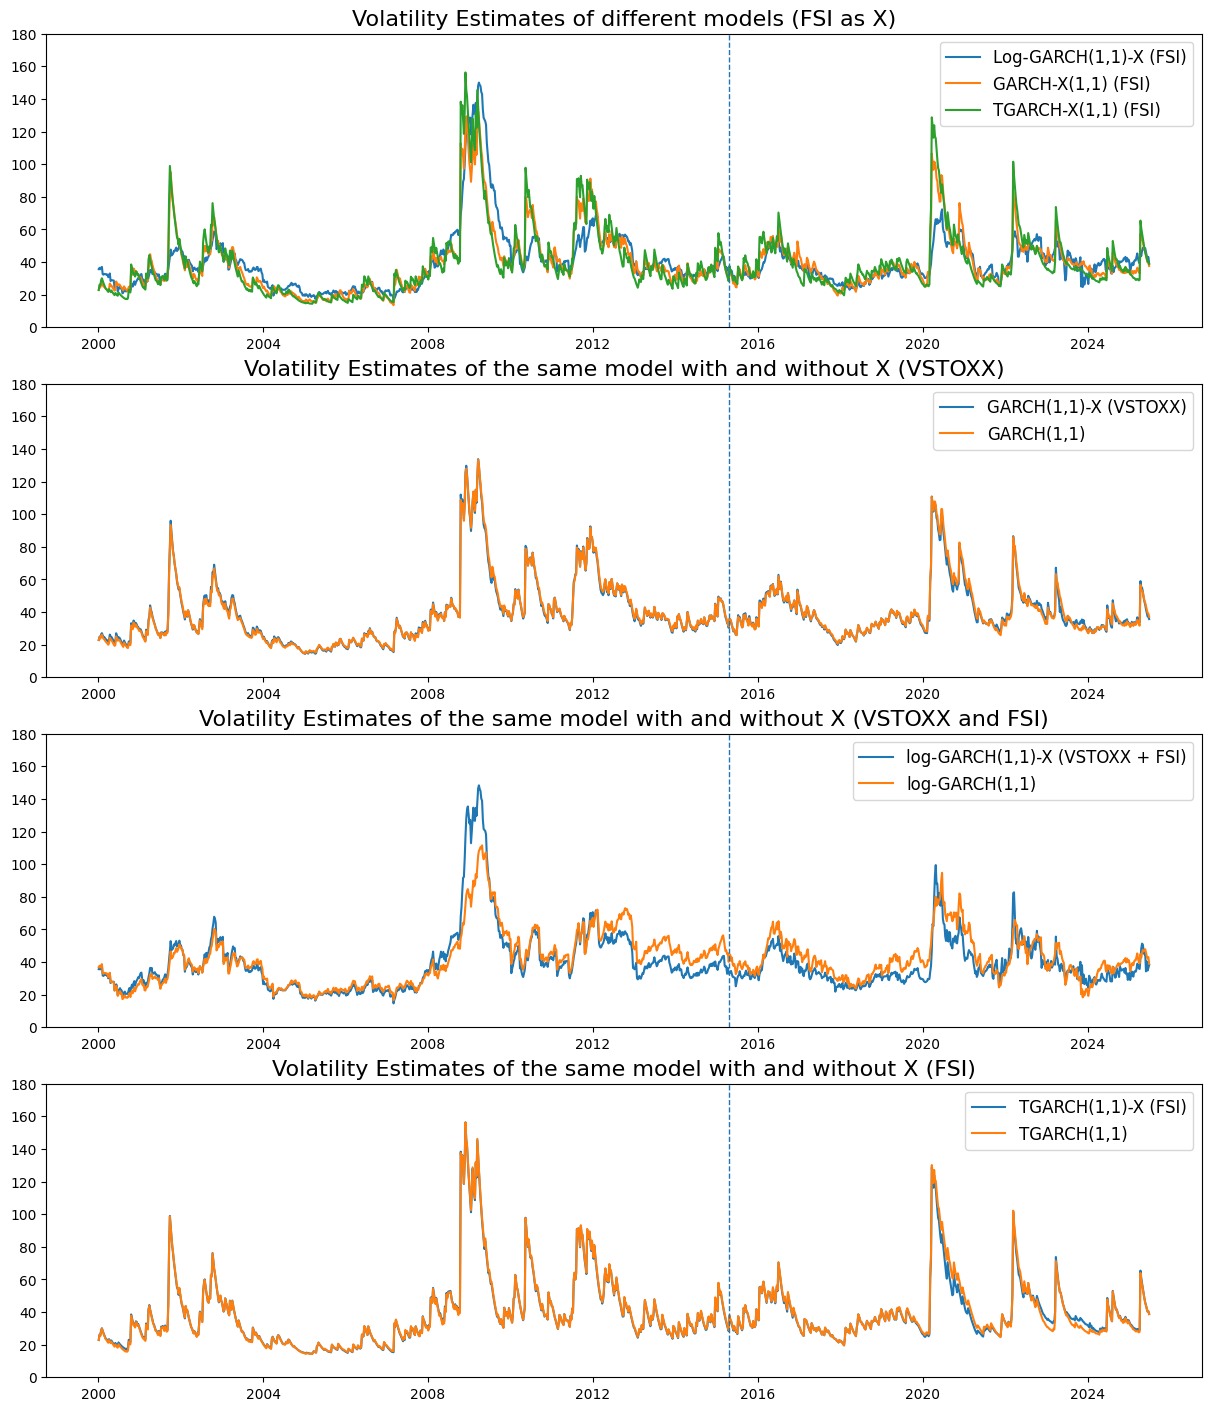

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index, vol_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index, vol_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index, vol_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')
axs[0].legend(loc="upper right", fontsize=12)
axs[0].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[0].set_title('Volatility Estimates of different models (FSI as X)', fontsize=16)
axs[0].set_ylim(0, 180)


axs[1].plot(combined.index, vol_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index, vol_GARCH, label='GARCH(1,1)')
axs[1].legend(loc="upper right", fontsize=12)
axs[1].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[1].set_title('Volatility Estimates of the same model with and without X (VSTOXX)', fontsize=16)
axs[1].set_ylim(0, 180)

axs[2].plot(combined.index, vol_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index, vol_Log_GARCH, label='log-GARCH(1,1)')
axs[2].legend(loc="upper right", fontsize=12)
axs[2].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[2].set_title('Volatility Estimates of the same model with and without X (VSTOXX and FSI)', fontsize=16)
axs[2].set_ylim(0, 180)

axs[3].plot(combined.index, vol_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index, vol_TGARCH, label='TGARCH(1,1)')
axs[3].legend(loc="upper right", fontsize=12)
axs[3].axvline(x=combined.index[:][T], linestyle='--', linewidth=1)
axs[3].set_title('Volatility Estimates of the same model with and without X (FSI)', fontsize=16)
axs[3].set_ylim(0, 180)

plt.show()

In [ ]:

std_loss_GARCH = np.zeros(H)
std_loss_GARCHX_FSI = np.zeros(H)
std_loss_GARCHX_VSTOXX = np.zeros(H)
std_loss_GARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_TGARCH = np.zeros(H)
std_loss_TGARCHX_FSI = np.zeros(H)
std_loss_TGARCHX_VSTOXX = np.zeros(H)
std_loss_TGARCHX_FSI_VSTOXX = np.zeros(H)

std_loss_Log_GARCH = np.zeros(H)
std_loss_Log_GARCHX_FSI = np.zeros(H)
std_loss_Log_GARCHX_VSTOXX = np.zeros(H)
std_loss_Log_GARCHX_FSI_VSTOXX = np.zeros(H)




std_loss_GARCH[0:T] = - (combined['Log Return'][0:T] - parameters_GARCH['Mu'][0]) / vol_GARCH[0:T].to_numpy()
std_loss_GARCHX_FSI[0:T] = - (combined['Log Return'][0:T] - parameters_GARCHX_FSI['Mu'][0]) / vol_GARCHX_FSI[0:T].to_numpy()
std_loss_GARCHX_VSTOXX[0:T] = - (combined['Log Return'][0:T] - parameters_GARCHX_VSTOXX['Mu'][0]) / vol_GARCHX_VSTOXX[0:T].to_numpy()
std_loss_GARCHX_FSI_VSTOXX[0:T] = - (combined['Log Return'][0:T] - parameters_GARCHX_FSI_VSTOXX['Mu'][0]) / vol_GARCHX_FSI_VSTOXX[0:T].to_numpy()

std_loss_TGARCH[0:T] = - (combined['Log Return'][0:T] - parameters_TGARCH['Mu'][0]) / vol_TGARCH[0:T].to_numpy()
std_loss_TGARCHX_FSI[0:T] = - (combined['Log Return'][0:T] - parameters_TGARCHX_FSI['Mu'][0]) / vol_TGARCHX_FSI[0:T].to_numpy()
std_loss_TGARCHX_VSTOXX[0:T] = - (combined['Log Return'][0:T] - parameters_TGARCHX_VSTOXX['Mu'][0]) / vol_TGARCHX_VSTOXX[0:T].to_numpy()
std_loss_TGARCHX_FSI_VSTOXX[0:T] = - (combined['Log Return'][0:T] - parameters_TGARCHX_FSI_VSTOXX['Mu'][0]) / vol_TGARCHX_FSI_VSTOXX[0:T].to_numpy()

std_loss_Log_GARCH[0:T] = - combined['Log Return'][0:T] / vol_Log_GARCH[0:T].to_numpy()
std_loss_Log_GARCHX_FSI[0:T] = - combined['Log Return'][0:T] / vol_Log_GARCHX_FSI[0:T].to_numpy()
std_loss_Log_GARCHX_VSTOXX[0:T] = - combined['Log Return'][0:T] / vol_Log_GARCHX_VSTOXX[0:T].to_numpy()
std_loss_Log_GARCHX_FSI_VSTOXX[0:T] = - combined['Log Return'][0:T] / vol_Log_GARCHX_FSI_VSTOXX[0:T].to_numpy()

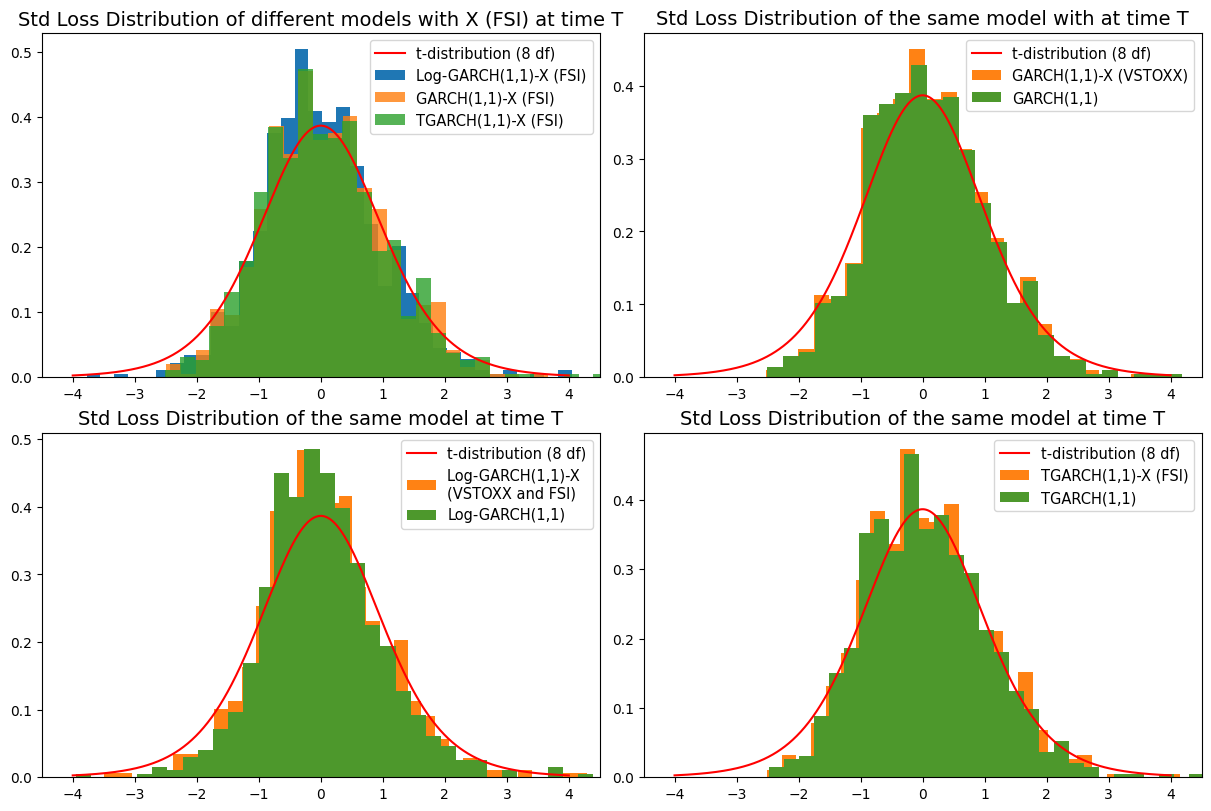

In [ ]:

x_ax_std = np.linspace(-4, 4, 1000)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axs[0,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,0].hist(std_loss_Log_GARCHX_FSI[0:T], bins=40, density=True)
axs[0,0].hist(std_loss_GARCHX_FSI[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].hist(std_loss_TGARCHX_FSI[0:T], bins=40, alpha=0.8,density=True)
axs[0,0].legend(['t-distribution (8 df)', 'Log-GARCH(1,1)-X (FSI)', 'GARCH(1,1)-X (FSI)', 'TGARCH(1,1)-X (FSI)'], loc='upper right', fontsize=10.5)
axs[0,0].set_xlim(-4.5, 4.5)
axs[0,0].set_title('Std Loss Distribution of different models with X (FSI) at time T', fontsize=14)

axs[0,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[0,1].hist(std_loss_GARCHX_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[0,1].hist(std_loss_GARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[0,1].legend(['t-distribution (8 df)', 'GARCH(1,1)-X (VSTOXX)', 'GARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[0,1].set_xlim(-4.5, 4.5)
axs[0,1].set_title('Std Loss Distribution of the same model with at time T', fontsize=14)

axs[1,0].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,0].hist(std_loss_Log_GARCHX_FSI_VSTOXX[0:T], bins=40, density=True, color='#ff8214')
axs[1,0].hist(std_loss_Log_GARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,0].legend(['t-distribution (8 df)', 'Log-GARCH(1,1)-X \n(VSTOXX and FSI)', 'Log-GARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,0].set_xlim(-4.5, 4.5)
axs[1,0].set_title('Std Loss Distribution of the same model at time T', fontsize=14)


axs[1,1].plot(x_ax_std, stats.t.pdf(x_ax_std, 8, 0, 1), color='r')
axs[1,1].hist(std_loss_TGARCHX_FSI[0:T], bins=40, density=True, color='#ff8214')
axs[1,1].hist(std_loss_TGARCH[0:T], bins=40, alpha=1,density=True, color='#4d982c')
axs[1,1].legend(['t-distribution (8 df)', 'TGARCH(1,1)-X (FSI)', 'TGARCH(1,1)'], loc='upper right', fontsize=10.5)
axs[1,1].set_xlim(-4.5, 4.5)
axs[1,1].set_title('Std Loss Distribution of the same model at time T', fontsize=14)





# #4d982c - green, #ff8214 - orange, #1f77b4 - blue


plt.show()

In [ ]:

VaR_GARCH = np.zeros(H-T)
VaR_GARCHX_FSI = np.zeros(H-T)
VaR_GARCHX_VSTOXX = np.zeros(H-T)
VaR_GARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_TGARCH = np.zeros(H-T)
VaR_TGARCHX_FSI = np.zeros(H-T)
VaR_TGARCHX_VSTOXX = np.zeros(H-T)
VaR_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_Log_GARCH = np.zeros(H-T)
VaR_Log_GARCHX_FSI = np.zeros(H-T)
VaR_Log_GARCHX_VSTOXX = np.zeros(H-T)
VaR_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)

VaR_naive = np.zeros(H-T)


ES_GARCH = np.zeros(H-T)
ES_GARCHX_FSI = np.zeros(H-T)
ES_GARCHX_VSTOXX = np.zeros(H-T)
ES_GARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_TGARCH = np.zeros(H-T)
ES_TGARCHX_FSI = np.zeros(H-T)
ES_TGARCHX_VSTOXX = np.zeros(H-T)
ES_TGARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_Log_GARCH = np.zeros(H-T)
ES_Log_GARCHX_FSI = np.zeros(H-T)
ES_Log_GARCHX_VSTOXX = np.zeros(H-T)
ES_Log_GARCHX_FSI_VSTOXX = np.zeros(H-T)

ES_naive = np.zeros(H-T)

for t in range(T,H):

  std_loss_GARCH[t] = - (combined['Log Return'].to_numpy()[t] - parameters_GARCH['Mu'][t-T]) / vol_GARCH[t]
  std_loss_GARCHX_FSI[t] = - (combined['Log Return'].to_numpy()[t] - parameters_GARCHX_FSI['Mu'][t-T]) / vol_GARCHX_FSI[t]
  std_loss_GARCHX_VSTOXX[t] = - (combined['Log Return'].to_numpy()[t] - parameters_GARCHX_VSTOXX['Mu'][t-T]) / vol_GARCHX_VSTOXX[t]
  std_loss_GARCHX_FSI_VSTOXX[t] = - (combined['Log Return'].to_numpy()[t] - parameters_GARCHX_FSI_VSTOXX['Mu'][t-T]) / vol_GARCHX_FSI_VSTOXX[t]

  std_loss_TGARCH[t] = - (combined['Log Return'].to_numpy()[t] - parameters_TGARCH['Mu'][t-T]) / vol_TGARCH[t]
  std_loss_TGARCHX_FSI[t] = - (combined['Log Return'].to_numpy()[t] - parameters_TGARCHX_FSI['Mu'][t-T]) / vol_TGARCHX_FSI[t]
  std_loss_TGARCHX_VSTOXX[t] = - (combined['Log Return'].to_numpy()[t] - parameters_TGARCHX_VSTOXX['Mu'][t-T]) / vol_TGARCHX_VSTOXX[t]
  std_loss_TGARCHX_FSI_VSTOXX[t] = - (combined['Log Return'].to_numpy()[t] - parameters_TGARCHX_FSI_VSTOXX['Mu'][t-T]) / vol_TGARCHX_FSI_VSTOXX[t]

  std_loss_Log_GARCH[t] = - combined['Log Return'].to_numpy()[t] / vol_Log_GARCH[t]
  std_loss_Log_GARCHX_FSI[t] = - combined['Log Return'].to_numpy()[t] / vol_Log_GARCHX_FSI[t]
  std_loss_Log_GARCHX_VSTOXX[t] = - combined['Log Return'].to_numpy()[t] / vol_Log_GARCHX_VSTOXX[t]
  std_loss_Log_GARCHX_FSI_VSTOXX[t] = - combined['Log Return'].to_numpy()[t] / vol_Log_GARCHX_FSI_VSTOXX[t]



  VaR_GARCH[t-T] = np.quantile(std_loss_GARCH[t-T:t], 0.95) * vol_GARCH[t] - parameters_GARCH['Mu'][t-T]
  VaR_GARCHX_FSI[t-T] = np.quantile(std_loss_GARCHX_FSI[t-T:t], 0.95) * vol_GARCHX_FSI[t] - parameters_GARCHX_FSI['Mu'][t-T]
  VaR_GARCHX_VSTOXX[t-T] = np.quantile(std_loss_GARCHX_VSTOXX[t-T:t], 0.95) * vol_GARCHX_VSTOXX[t] - parameters_GARCHX_VSTOXX['Mu'][t-T]
  VaR_GARCHX_FSI_VSTOXX[t-T] = np.quantile(std_loss_GARCHX_FSI_VSTOXX[t-T:t], 0.95) * vol_GARCHX_FSI_VSTOXX[t] - parameters_GARCHX_FSI_VSTOXX['Mu'][t-T]

  VaR_TGARCH[t-T] = np.quantile(std_loss_TGARCH[t-T:t], 0.95) * vol_TGARCH[t] - parameters_TGARCH['Mu'][t-T]
  VaR_TGARCHX_FSI[t-T] = np.quantile(std_loss_TGARCHX_FSI[t-T:t], 0.95) * vol_TGARCHX_FSI[t] - parameters_TGARCHX_FSI['Mu'][t-T]
  VaR_TGARCHX_VSTOXX[t-T] = np.quantile(std_loss_TGARCHX_VSTOXX[t-T:t], 0.95) * vol_TGARCHX_VSTOXX[t] - parameters_TGARCHX_VSTOXX['Mu'][t-T]
  VaR_TGARCHX_FSI_VSTOXX[t-T] = np.quantile(std_loss_TGARCHX_FSI_VSTOXX[t-T:t], 0.95) * vol_TGARCHX_FSI_VSTOXX[t] - parameters_TGARCHX_FSI_VSTOXX['Mu'][t-T]

  VaR_Log_GARCH[t-T] = np.quantile(std_loss_Log_GARCH[t-T:t], 0.95) * vol_Log_GARCH[t]
  VaR_Log_GARCHX_FSI[t-T] = np.quantile(std_loss_Log_GARCHX_FSI[t-T:t], 0.95) * vol_Log_GARCHX_FSI[t]
  VaR_Log_GARCHX_VSTOXX[t-T] = np.quantile(std_loss_Log_GARCHX_VSTOXX[t-T:t], 0.95) * vol_Log_GARCHX_VSTOXX[t]
  VaR_Log_GARCHX_FSI_VSTOXX[t-T] = np.quantile(std_loss_Log_GARCHX_FSI_VSTOXX[t-T:t], 0.95) * vol_Log_GARCHX_FSI_VSTOXX[t]

  VaR_naive[t-T] = np.quantile(-combined['Log Return'][t-T:t], 0.95)


  ES_GARCH[t-T] = ((np.mean(std_loss_GARCH[t-T:t][std_loss_GARCH[t-T:t] * vol_GARCH[t] - parameters_GARCH['Mu'][t-T] > VaR_GARCH[t-T]])
                   * vol_GARCH[t] - parameters_GARCH['Mu'][t-T]) )
  ES_GARCHX_FSI[t-T] = ((np.mean(std_loss_GARCHX_FSI[t-T:t][std_loss_GARCHX_FSI[t-T:t] * vol_GARCHX_FSI[t] - parameters_GARCHX_FSI['Mu'][t-T] > VaR_GARCHX_FSI[t-T]])
                   * vol_GARCHX_FSI[t] - parameters_GARCHX_FSI['Mu'][t-T]) )
  ES_GARCHX_VSTOXX[t-T] = ((np.mean(std_loss_GARCHX_VSTOXX[t-T:t][std_loss_GARCHX_VSTOXX[t-T:t] * vol_GARCHX_VSTOXX[t] - parameters_GARCHX_VSTOXX['Mu'][t-T] > VaR_GARCHX_VSTOXX[t-T]])
                   * vol_GARCHX_VSTOXX[t] - parameters_GARCHX_VSTOXX['Mu'][t-T]) )
  ES_GARCHX_FSI_VSTOXX[t-T] = ((np.mean(std_loss_GARCHX_FSI_VSTOXX[t-T:t][std_loss_GARCHX_FSI_VSTOXX[t-T:t] * vol_GARCHX_FSI_VSTOXX[t] - parameters_GARCHX_FSI_VSTOXX['Mu'][t-T] > VaR_GARCHX_FSI_VSTOXX[t-T]])
                   * vol_GARCHX_FSI_VSTOXX[t] - parameters_GARCHX_FSI_VSTOXX['Mu'][t-T]) )

  ES_TGARCH[t-T] = ((np.mean(std_loss_TGARCH[t-T:t][std_loss_TGARCH[t-T:t] * vol_TGARCH[t] - parameters_TGARCH['Mu'][t-T] > VaR_TGARCH[t-T]])
                   * vol_TGARCH[t] - parameters_TGARCH['Mu'][t-T]) )
  ES_TGARCHX_FSI[t-T] = ((np.mean(std_loss_TGARCHX_FSI[t-T:t][std_loss_TGARCHX_FSI[t-T:t] * vol_TGARCHX_FSI[t] - parameters_TGARCHX_FSI['Mu'][t-T] > VaR_TGARCHX_FSI[t-T]])
                   * vol_TGARCHX_FSI[t] - parameters_TGARCHX_FSI['Mu'][t-T]) )
  ES_TGARCHX_VSTOXX[t-T] = ((np.mean(std_loss_TGARCHX_VSTOXX[t-T:t][std_loss_TGARCHX_VSTOXX[t-T:t] * vol_TGARCHX_VSTOXX[t] - parameters_TGARCHX_VSTOXX['Mu'][t-T] > VaR_TGARCHX_VSTOXX[t-T]])
                   * vol_TGARCHX_VSTOXX[t] - parameters_TGARCHX_VSTOXX['Mu'][t-T]) )
  ES_TGARCHX_FSI_VSTOXX[t-T] = ((np.mean(std_loss_TGARCHX_FSI_VSTOXX[t-T:t][std_loss_TGARCHX_FSI_VSTOXX[t-T:t] * vol_TGARCHX_FSI_VSTOXX[t] - parameters_TGARCHX_FSI_VSTOXX['Mu'][t-T] > VaR_TGARCHX_FSI_VSTOXX[t-T]])
                   * vol_TGARCHX_FSI_VSTOXX[t] - parameters_TGARCHX_FSI_VSTOXX['Mu'][t-T]) )

  ES_Log_GARCH[t-T] = np.mean(std_loss_Log_GARCH[t-T:t][std_loss_Log_GARCH[t-T:t] * vol_Log_GARCH[t] > VaR_Log_GARCH[t-T]]) * vol_Log_GARCH[t]
  ES_Log_GARCHX_FSI[t-T] = np.mean(std_loss_Log_GARCHX_FSI[t-T:t][std_loss_Log_GARCHX_FSI[t-T:t] * vol_Log_GARCHX_FSI[t] > VaR_Log_GARCHX_FSI[t-T]]) * vol_Log_GARCHX_FSI[t]
  ES_Log_GARCHX_VSTOXX[t-T] = np.mean(std_loss_Log_GARCHX_VSTOXX[t-T:t][std_loss_Log_GARCHX_VSTOXX[t-T:t] * vol_Log_GARCHX_VSTOXX[t] > VaR_Log_GARCHX_VSTOXX[t-T]]) * vol_Log_GARCHX_VSTOXX[t]
  ES_Log_GARCHX_FSI_VSTOXX[t-T] = (np.mean(std_loss_Log_GARCHX_FSI_VSTOXX[t-T:t][std_loss_Log_GARCHX_FSI_VSTOXX[t-T:t] * vol_Log_GARCHX_FSI_VSTOXX[t] > VaR_Log_GARCHX_FSI_VSTOXX[t-T]])
                   * vol_Log_GARCHX_FSI_VSTOXX[t] )

  ES_naive[t-T] = np.mean(-combined['Log Return'][t-T:t][-combined['Log Return'][t-T:t] > VaR_naive[t-T]])

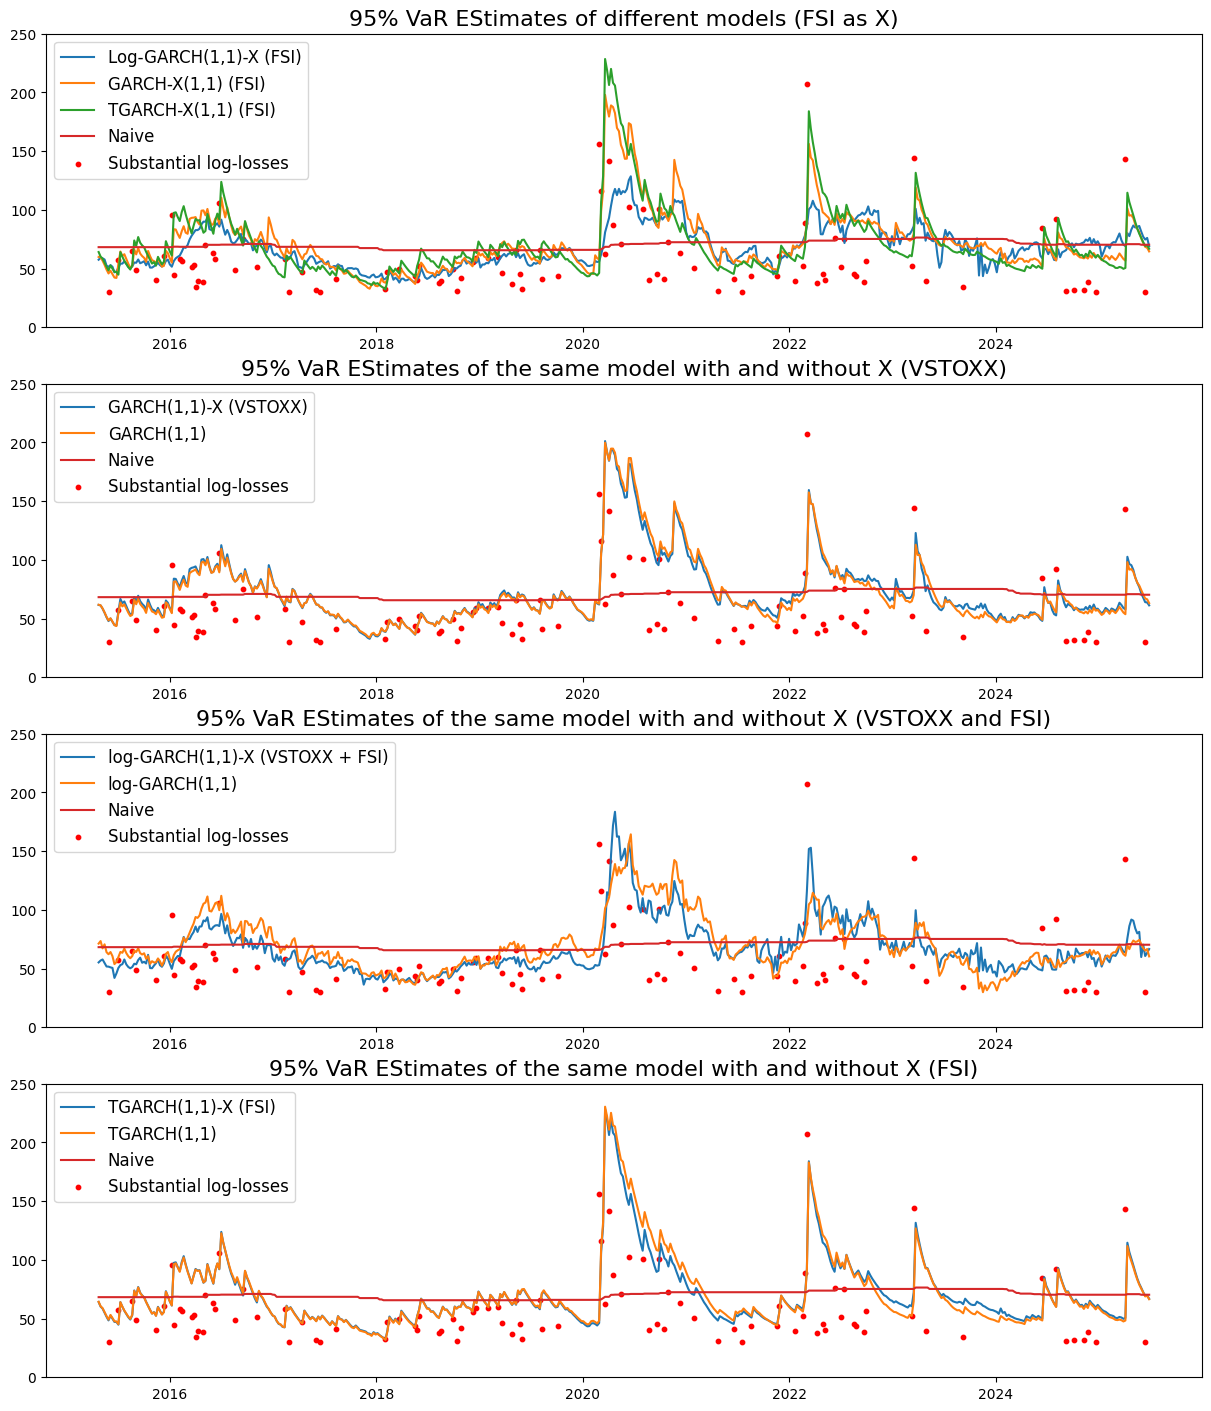

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], VaR_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index[T:H], VaR_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], VaR_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('95% VaR EStimates of different models (FSI as X)', fontsize=16)
axs[0].set_ylim(0, 250)


axs[1].plot(combined.index[T:H], VaR_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index[T:H], VaR_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('95% VaR EStimates of the same model with and without X (VSTOXX)', fontsize=16)
axs[1].set_ylim(0, 250)

axs[2].plot(combined.index[T:H], VaR_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index[T:H], VaR_Log_GARCH, label='log-GARCH(1,1)')
axs[2].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('95% VaR EStimates of the same model with and without X (VSTOXX and FSI)', fontsize=16)
axs[2].set_ylim(0, 250)

axs[3].plot(combined.index[T:H], VaR_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index[T:H], VaR_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], VaR_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < -30], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < -30], label='Substantial log-losses', color='r',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('95% VaR EStimates of the same model with and without X (FSI)', fontsize=16)
axs[3].set_ylim(0, 250)

plt.show()

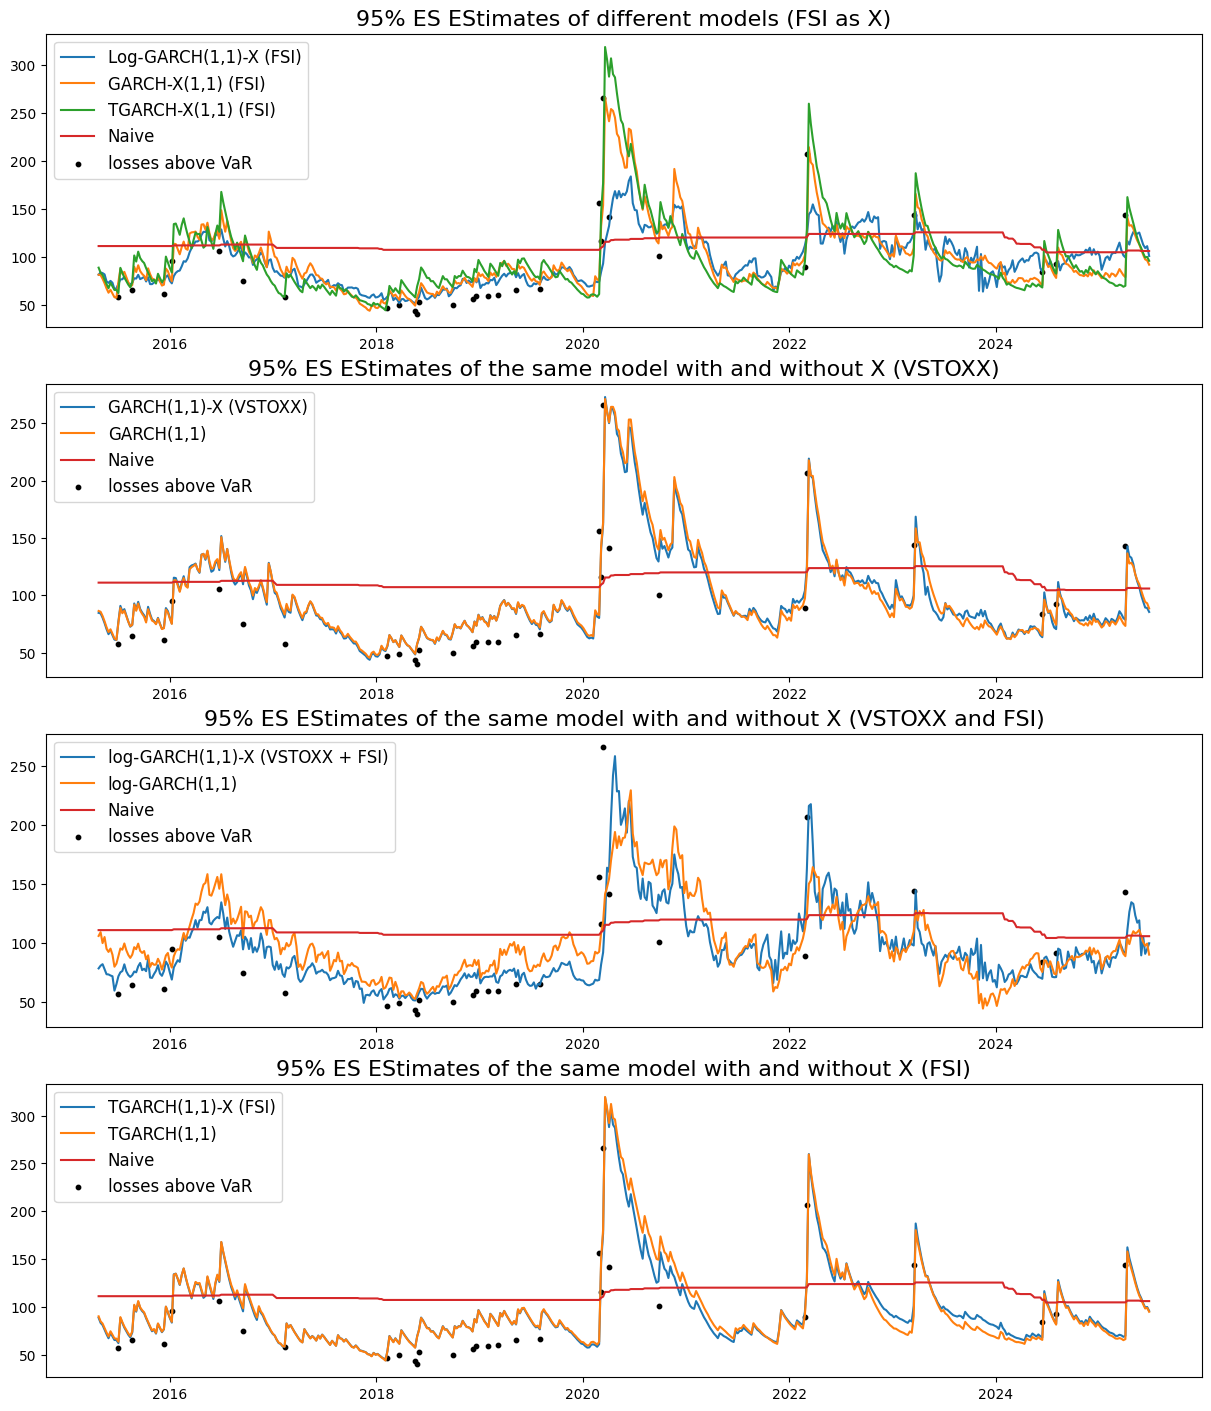

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)


axs[0].plot(combined.index[T:H], ES_Log_GARCHX_FSI, label='Log-GARCH(1,1)-X (FSI)')
axs[0].plot(combined.index[T:H], ES_GARCHX_FSI, label='GARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], ES_TGARCHX_FSI, label='TGARCH-X(1,1) (FSI)')
axs[0].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[0].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[0].legend(loc="upper left", fontsize=12)
axs[0].set_title('95% ES EStimates of different models (FSI as X)', fontsize=16)
#axs[0].set_ylim(0, 250)


axs[1].plot(combined.index[T:H], ES_GARCHX_VSTOXX, label='GARCH(1,1)-X (VSTOXX)')
axs[1].plot(combined.index[T:H], ES_GARCH, label='GARCH(1,1)')
axs[1].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[1].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[1].legend(loc="upper left", fontsize=12)
axs[1].set_title('95% ES EStimates of the same model with and without X (VSTOXX)', fontsize=16)
#axs[1].set_ylim(0, 250)

axs[2].plot(combined.index[T:H], ES_Log_GARCHX_FSI_VSTOXX, label='log-GARCH(1,1)-X (VSTOXX + FSI)')
axs[2].plot(combined.index[T:H], ES_Log_GARCH, label='log-GARCH(1,1)')
axs[2].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[2].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[2].legend(loc="upper left", fontsize=12)
axs[2].set_title('95% ES EStimates of the same model with and without X (VSTOXX and FSI)', fontsize=16)
#axs[2].set_ylim(0, 250)

axs[3].plot(combined.index[T:H], ES_TGARCHX_FSI, label='TGARCH(1,1)-X (FSI)')
axs[3].plot(combined.index[T:H], ES_TGARCH, label='TGARCH(1,1)')
axs[3].plot(combined.index[T:H], ES_naive, label='Naive', color='#d62829')
axs[3].scatter(combined[T:H].index[combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], -combined[['Log Return']][T:H][combined[T:H]['Log Return'] < - VaR_Log_GARCHX_FSI_VSTOXX], label='losses above VaR', color='black',  s=10)
axs[3].legend(loc="upper left", fontsize=12)
axs[3].set_title('95% ES EStimates of the same model with and without X (FSI)', fontsize=16)
#axs[3].set_ylim(0, 250)

plt.show()

In [ ]:
def Scroing_func(r1,r2,Y, alpha):
  S = np.where(Y > r1, 1, 0) * (Y - r1) / (2 * np.sqrt(r2)) + (1 - alpha) * (r1+r2) / (2 * np.sqrt(r2))
  return S

In [ ]:

av_Score_GARCH = np.mean(Scroing_func(VaR_GARCH, ES_GARCH, -combined['Log Return'][T:H], 0.05))
av_Score_GARCHX_FSI = np.mean(Scroing_func(VaR_GARCHX_FSI, ES_GARCHX_FSI, -combined['Log Return'][T:H], 0.05))
av_Score_GARCHX_VSTOXX = np.mean(Scroing_func(VaR_GARCHX_VSTOXX, ES_GARCHX_VSTOXX, -combined['Log Return'][T:H], 0.05))
av_Score_GARCHX_FSI_VSTOXX = np.mean(Scroing_func(VaR_GARCHX_FSI_VSTOXX, ES_GARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.05))

av_Score_TGARCH = np.mean(Scroing_func(VaR_TGARCH, ES_TGARCH, -combined['Log Return'][T:H], 0.05))
av_Score_TGARCHX_FSI = np.mean(Scroing_func(VaR_TGARCHX_FSI, ES_TGARCHX_FSI, -combined['Log Return'][T:H], 0.05))
av_Score_TGARCHX_VSTOXX = np.mean(Scroing_func(VaR_TGARCHX_VSTOXX, ES_TGARCHX_VSTOXX, -combined['Log Return'][T:H], 0.05))
av_Score_TGARCHX_FSI_VSTOXX = np.mean(Scroing_func(VaR_TGARCHX_FSI_VSTOXX, ES_TGARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.05))

av_Score_Log_GARCH = np.mean(Scroing_func(VaR_Log_GARCH, ES_Log_GARCH, -combined['Log Return'][T:H], 0.05))
av_Score_Log_GARCHX_FSI = np.mean(Scroing_func(VaR_Log_GARCHX_FSI, ES_Log_GARCHX_FSI, -combined['Log Return'][T:H], 0.05))
av_Score_Log_GARCHX_VSTOXX = np.mean(Scroing_func(VaR_Log_GARCHX_VSTOXX, ES_Log_GARCHX_VSTOXX, -combined['Log Return'][T:H], 0.05))
av_Score_Log_GARCHX_FSI_VSTOXX = np.mean(Scroing_func(VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.05))

av_Score_naive = np.mean(Scroing_func(VaR_naive, ES_naive, -combined['Log Return'][T:H], 0.05))



print(f'Average Score GARCH(1,1): {np.round(av_Score_GARCH, 4)}')
print(f'Average Score GARCH(1,1)-X (FSI): {np.round(av_Score_GARCHX_FSI, 4)}')
print(f'Average Score GARCH(1,1)-X (VSTOXX): {np.round(av_Score_GARCHX_VSTOXX, 4)}')
print(f'Average Score GARCH(1,1)-X (FSI + VSTOXX): {np.round(av_Score_GARCHX_FSI_VSTOXX, 4)}')
print('\n')
print(f'Average Score TGARCH(1,1,): {np.round(av_Score_TGARCH, 4)}')
print(f'Average Score TGARCH(1,1)-X (FSI): {np.round(av_Score_TGARCHX_FSI, 4)}')
print(f'Average Score TGARCH(1,1)-X (VSTOXX): {np.round(av_Score_TGARCHX_VSTOXX, 4)}')
print(f'Average Score TGARCH(1,1)-X (FSI + VSTOXX): {np.round(av_Score_TGARCHX_FSI_VSTOXX, 4)}')
print('\n')
print(f'Average Score Log-GARCH(1,1): {np.round(av_Score_Log_GARCH, 4)}')
print(f'Average Score Log-GARCH(1,1)-X (FSI): {np.round(av_Score_Log_GARCHX_FSI, 4)}')
print(f'Average Score Log-GARCH(1,1)-X (VSTOXX): {np.round(av_Score_Log_GARCHX_VSTOXX, 4)}')
print(f'Average Score Log-GARCH(1,1)-X (FSI + VSTOXX): {np.round(av_Score_Log_GARCHX_FSI_VSTOXX, 4)}')
print('\n')
print(f'Average Score Naive: {np.round(av_Score_naive, 4)}')

Average Score GARCH(1,1): 8.0951
Average Score GARCH(1,1)-X (FSI): 8.1295
Average Score GARCH(1,1)-X (VSTOXX): 8.1203
Average Score GARCH(1,1)-X (FSI + VSTOXX): 8.094


Average Score TGARCH(1,1,): 8.0408
Average Score TGARCH(1,1)-X (FSI): 8.0342
Average Score TGARCH(1,1)-X (VSTOXX): 7.9996
Average Score TGARCH(1,1)-X (FSI + VSTOXX): 7.9712


Average Score Log-GARCH(1,1): 8.0725
Average Score Log-GARCH(1,1)-X (FSI): 7.9467
Average Score Log-GARCH(1,1)-X (VSTOXX): 7.9156
Average Score Log-GARCH(1,1)-X (FSI + VSTOXX): 7.8783


Average Score Naive: 8.2726


In [ ]:
d_t = Scroing_func(VaR_Log_GARCHX_FSI_VSTOXX, ES_Log_GARCHX_FSI_VSTOXX, -combined['Log Return'][T:H], 0.05) - Scroing_func(VaR_GARCH, ES_GARCH, -combined['Log Return'][T:H], 0.05)
def sample_autocov(u_t, h):
 return 1 / len(u_t) * np.sum(u_t[h:] * u_t[:len(u_t) - h])

def QS_kernel(x):
  if x == 0:
    return 1
  else:
    QS1 = 25/(12 * (np.pi * x)**2)
    QS2 = np.sin(6 * np.pi * x / 5) / (6 * np.pi * x / 5)
    QS3 = np.cos(6 * np.pi * x / 5)
  return QS1 * (QS2 - QS3)


def hac_est_Andrews(d_t, b):
  u_t = d_t - np.mean(d_t)
  gamma_vector = np.zeros((len(u_t)-1,1))
  w = [QS_kernel((l+1)/b) for l in range(len(u_t)-1)]
  for l in range(len(u_t)-1):
    gamma_vector[l] = sample_autocov(u_t, l + 1)
  gamma_0 = sample_autocov(u_t, 0)
  return np.sqrt(gamma_0 + 2 * np.dot(gamma_vector.T, w))

def compute_b(s_t):
  y = np.asarray(s_t, float)[1:]
  x = np.asarray(s_t, float)[:-1]
  rho_hat = sm.OLS(y, sm.add_constant(x)).fit().params[1]
  alpha2 = 4 * rho_hat **2 / (1 - rho_hat) ** 4
  return 1.3221 * (len(s_t) * alpha2) ** 0.2

b = compute_b(d_t)



stat = -np.mean(d_t)/(hac_est_Andrews(d_t, b) / np.sqrt(len(d_t)))

print(f'Statistic: {np.round(stat,4)}')
print(f' p-value: {np.round(stats.norm.sf(stat),4)}')



Statistic: [1.9077]
 p-value: [0.0282]


In [ ]:
combined.to_csv('combined.csv')

# **Daily**

In [ ]:
combined_daily = pd.concat([log_returns, VSTOXX['VSTOXX'], fsi['FSI']], axis=1)
combined_daily = combined_daily[320:6910] #removing missing periods
combined_daily

num_rows_with_na = combined_daily.isna().any(axis=1)
combined_daily[num_rows_with_na]


,Close,VSTOXX,FSI
Date,,,
2000-01-17,-0.064861,25.9901,NaN
2000-02-21,4.849219,30.9721,NaN
2000-04-24,NaN,NaN,0.472
2000-05-01,-0.574291,NaN,0.348
2000-05-29,2.444873,26.2538,NaN
...,...,...,...
2024-12-31,NaN,NaN,-0.419
2025-01-01,NaN,NaN,-0.417
2025-04-18,NaN,NaN,0.366


In [16]:
H

1330